In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.signal
import fklab.signals.filter
import fklab.signals.multitaper as mt
import fklab.signals.smooth as smooth
from fklab.signals.filter import apply_high_pass_filter
from fklab.signals import filter as filt
import fklab.signals.core as sig

import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook
plt.style.use('seaborn-ticks')

import matplotlib.colors
import matplotlib.cm

import fklab.ratemap as rm
import fklab.ratemap.utilities
import fklab.behavior.simulation
import fklab.spikes.simulation
import fklab.plot.plots
import fklab.geometry.shapes as shapes


from data_analysis import loading
from fklab.spikes.Kilosort import KiloSortResult

import seaborn as sns

from scipy.signal import decimate
import itertools


import fklab.segments
import fklab.events
import fklab.signals.core
import fklab.signals.smooth
import fklab.signals.theta

import fklab.utilities.general

from fklab.events.basic_algorithms import peri_event_histogram

from fklab.events.basic_algorithms import fastbin

In [2]:
loading.load_position('/mnt/fk-fileserver/Project_LS/LS_k_7/310720/2020-07-31_11-51-05/DLC/epochs/training/position.hdf5')
loading.load_position_yaml()
loading.load_environment_yaml()

In [3]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (16, 12)

from IPython.core.display import display, HTML

# import
from fklab.signals.time_alignment import *
from fklab.io.neuralynx.nlx_sync import nlx_retrieve_event, nlx_start_recording_time
from fklab.io.spikeGLX.glx_sync import glx_extra_sync_signal

In [4]:
align_file = Path('time_offset.h5')

if align_file.exists():
    ta = TimeAlignment.load(align_file)
else:
    # load Neuralynx data
    nlx_file = Path('/mnt/fk-fileserver/Project_LS/LS_k_7/310720/2020-07-31_11-51-05/DLC/Events.nev')
    nlx_data = nlx_retrieve_event(nlx_file)

    # load Neuropixels data
    glx_file = Path('/mnt/fk-fileserver/Project_LS/LS_k_7/310720/310720_g0/310720_g0_imec0/310720_g0_t0.imec0.lf.bin')
    glx_data = glx_extra_sync_signal(glx_file)

    # here use another style to create a TimeAlignment instance.
    ta = TimeAlignment({
        'nlx': nlx_data,
        'npx': glx_data
    })

    # trigger time alignment, and exam whether the value make sense or not.
    print(ta.avg_time_offset('npx'))

    # save into file
    #ta.save(align_file)

(-1830.4460715789062, 0.0030453830419969355)


In [5]:
from fklab.spikes.Kilosort.utilities_kilosort import KiloSortResult

ks = KiloSortResult('/mnt/fk-fileserver/Project_LS/LS_k_7/310720/310720_g0/310720_g0_imec0/catgt_310720_g0/params.py') # load kilosort result
cluster_ids = ks.get_good_cluster_group() 
#cluster_ids_LS = [i for i in cluster_ids if i < 471]
spike_t = {}
for cl in cluster_ids:
    spike_t[cl] = ta.time_map('nlx', ks.time_sec(ks.get_spike_time(ks.get_spike_for_cluster(cl))))
    spike_t[cl] = spike_t[cl][~np.isnan(spike_t[cl])]

In [6]:
#loading spiking data
project_root = '/mnt/fk-fileserver/Project_LS/LS_k_7/310720/310720_g0/310720_g0_imec0/catgt_310720_g0/'
Fs=3000
clusters = np.load(project_root + "spike_clusters.npy")
# print(clusters)
spike_times = np.load(project_root + "spike_times.npy") / Fs
#print(spike_times)
spike_templates = np.load(project_root + "templates.npy")

y_coords = np.load(project_root + "channel_positions.npy")
#print(y_coords)
spike_clusters = np.load(project_root + "spike_clusters.npy")

In [7]:
#loading clusters 
dtype = np.dtype([
    ('id', np.int),
    ('Amplitude', np.float),
    ('ContamPct', np.float),
    ('KSLabel', np.dtype('U5')),
    ('amp', np.float),
    ('channel', np.int),
    ('depth', np.float),
    ('firing_rate', np.float),
    ('group', np.dtype('U5')),
    ('n_spikes', np.int),
    ('shank', np.int),
])

data = np.loadtxt(project_root + "cluster_info.tsv",
                 dtype=dtype, skiprows=1, delimiter='\t',
                 converters={
    1:lambda it: float(it) if len(it) else np.nan,
    2:lambda it: float(it) if len(it) else np.nan,
    7:lambda fr: fr.replace(b' spk/s', b'')})
#print(data[data['KSLabel'] == 'good'])
# data_good = data[data['KSLabel']== 'good']
data_good = data[data['group'] == 'good']

In [8]:
depth = data_good['depth']
n_spk = data_good['n_spikes']
id_s = data_good['id']
channel= data_good['channel']

Text(0, 0.5, 'depth')

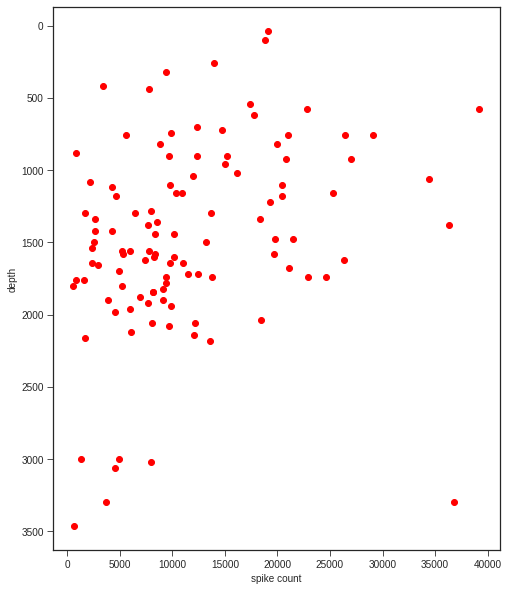

In [9]:
plt.rcParams["figure.figsize"] = (8,10)
plt.scatter(n_spk, depth, color='r')
plt.gca().invert_yaxis()
plt.xlabel('spike count')
plt.ylabel('depth')

In [10]:
epoch = loading.position_yaml['source']['epoch']
epoch
Y_maze_epoch = [1838,3431]

In [11]:
position_time1 = np.array(loading.position_time)

nan_array = np.isnan(position_time1)
not_nan_array = ~ nan_array
position_time = position_time1[not_nan_array]

position_at = loading.position[np.logical_and(position_time> Y_maze_epoch[0],
                                     position_time < Y_maze_epoch[1]), :]
position_at_cm = position_at * 0.5

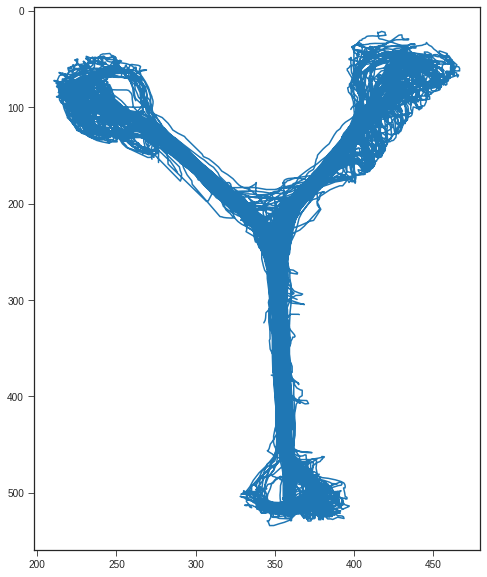

In [12]:
from fklab.behavior.preprocessing import compute_velocity
x=position_at[:,0]
y=position_at[:,1]

xy = np.column_stack([position_at])
#dt=1/25
velocity = compute_velocity(xy, dx=1.0, smooth=None)
speed = np.abs(velocity)
treshold_speed = 5
treshold_speed_fast = 10
# compute heading direction
phi = np.angle(velocity)
plt.plot(x,y)
plt.gca().invert_yaxis()

In [13]:
from fklab.geometry.shapes import graph, polyline
Y_maze_data = loading.environment_yaml['ymaze']['shapes']['ymaze']['shape']
Y_maze_data['polylines'] = [polyline(**p) if not isinstance(p, polyline) else p for p in Y_maze_data['polylines']]
ymaze = graph(**Y_maze_data)

In [14]:
from fklab.geometry.shapes import graph, polyline, rectangle, polygon
RR = loading.environment_yaml['ymaze']['shapes']['RR']['shape']
RR = rectangle(**RR)
RR = RR.aspolygon()

LR = loading.environment_yaml['ymaze']['shapes']['LR']['shape']
LR = rectangle(**LR)
LR = LR.aspolygon()

HR = loading.environment_yaml['ymaze']['shapes']['HR']['shape']
HR = rectangle(**HR)
HR = HR.aspolygon()

CP = loading.environment_yaml['ymaze']['shapes']['CP']['shape']
CP = rectangle(**CP)
CP = CP.aspolygon()

w_CP = loading.environment_yaml['ymaze']['shapes']['with_CP']['shape']
w_CP = rectangle(**w_CP)
w_CP = w_CP.aspolygon()

In [15]:
from fklab.behavior.task_analysis import detect_trajectories

outbound_right = detect_trajectories(position_time, xy, include_regions=[HR,CP,RR], exclude_regions=[LR], ordered=True, revisit=False)
outbound_left = detect_trajectories(position_time, xy, include_regions= [HR, CP,LR], exclude_regions=[RR], ordered=True, revisit=True)
inbound_right = detect_trajectories(position_time, xy, include_regions= [RR, CP,HR], ordered=True, revisit=True)
inbound_left = detect_trajectories(position_time, xy, include_regions= [LR, CP,HR], ordered=True, revisit=True)
choice = detect_trajectories(position_time, xy, include_regions= [HR,CP], ordered=True, revisit=True)
outbound=outbound_right.union(outbound_left)
inbound=inbound_right.union(inbound_left)
out_in = outbound.union(inbound)
right=detect_trajectories(position_time, xy, include_regions=[CP,RR], exclude_regions=[LR], ordered=True, revisit=False)
left=detect_trajectories(position_time, xy, include_regions=[CP,LR], exclude_regions=[LR], ordered=True, revisit=False)
right_in=detect_trajectories(position_time, xy, include_regions=[RR,CP], exclude_regions=[LR], ordered=True, revisit=False)
left_in=detect_trajectories(position_time, xy, include_regions=[LR,CP], exclude_regions=[RR], ordered=True, revisit=False)

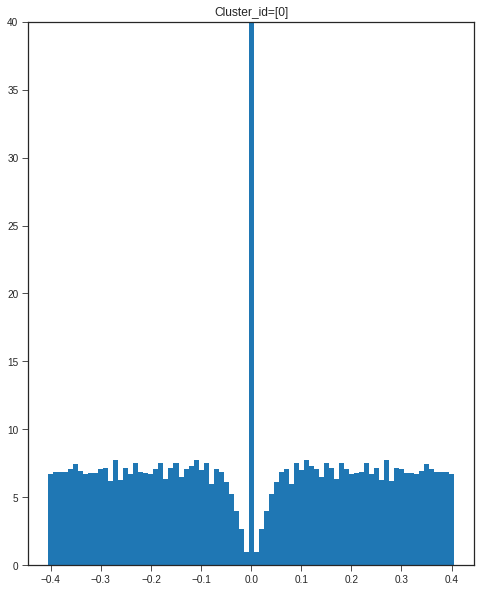

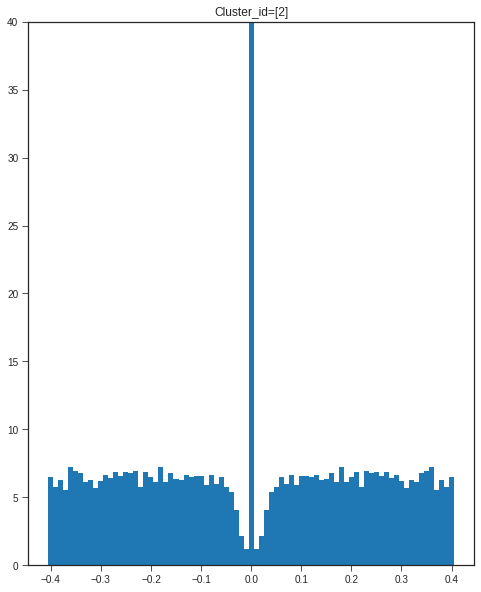

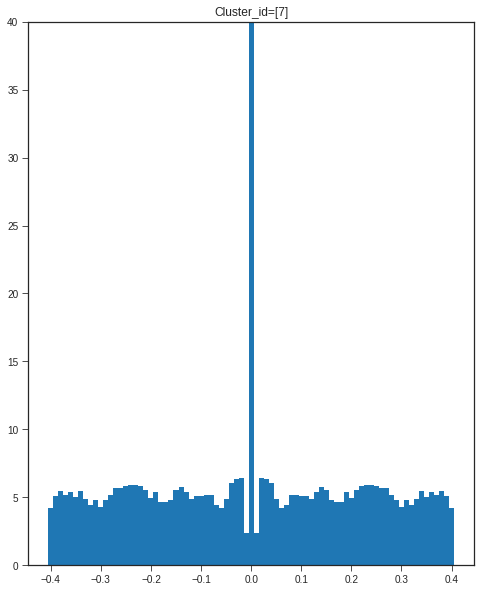

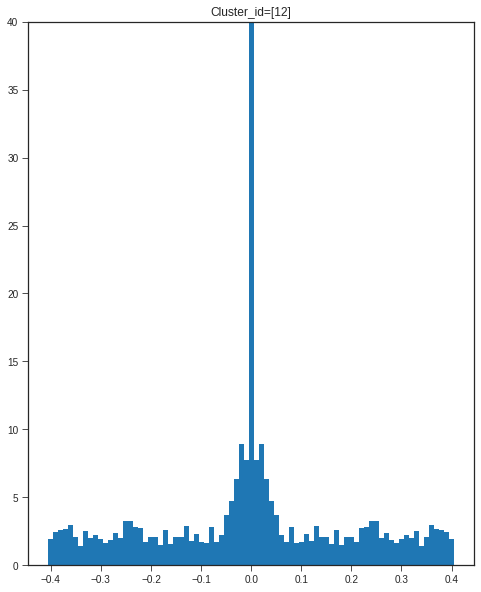

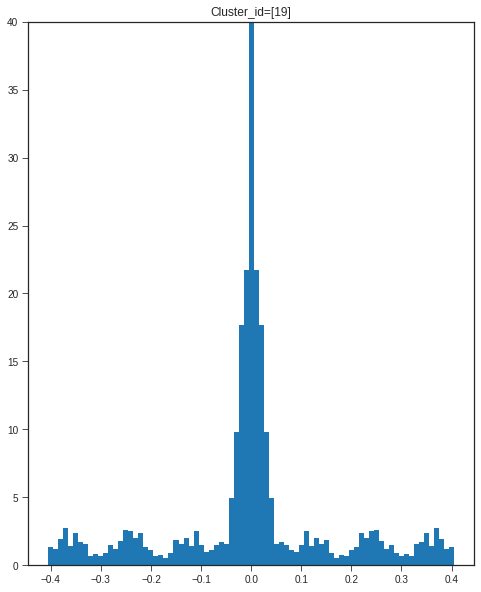

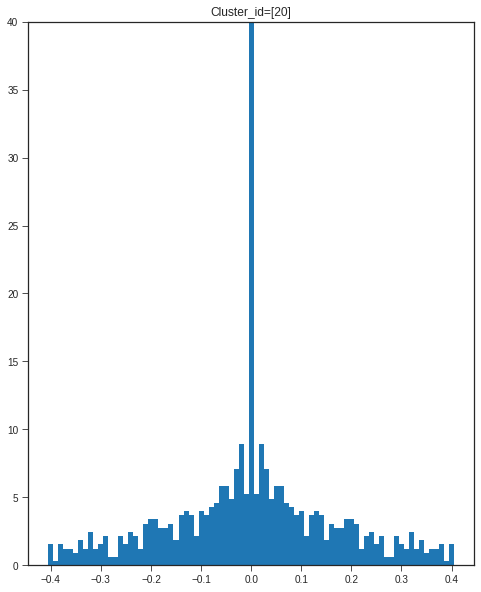

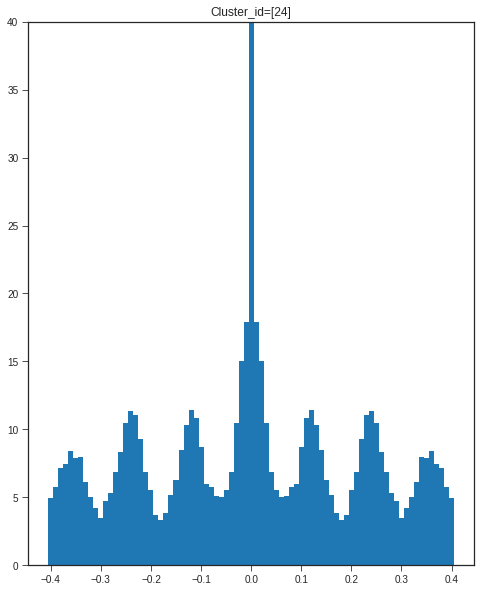

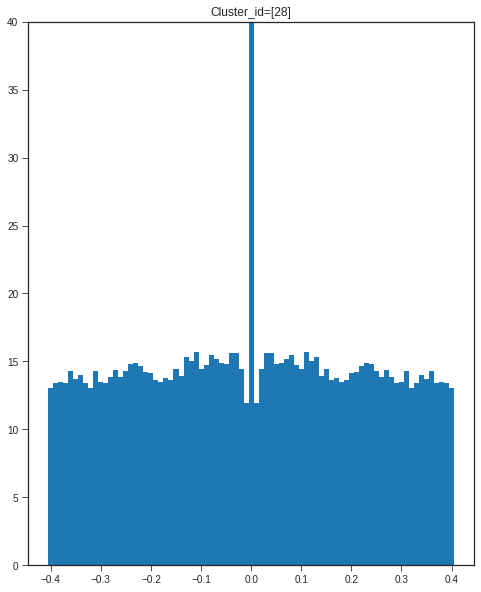

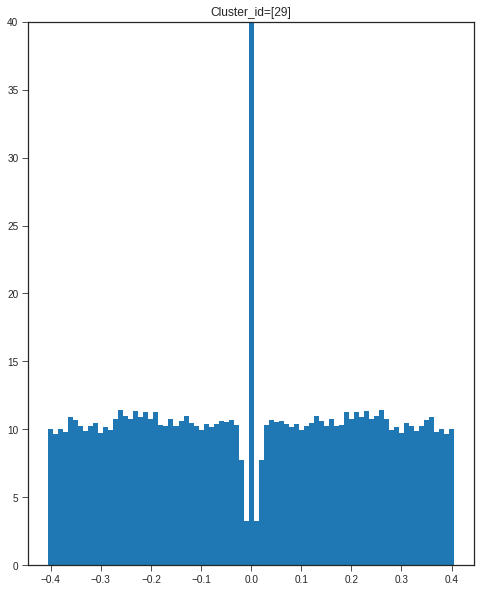

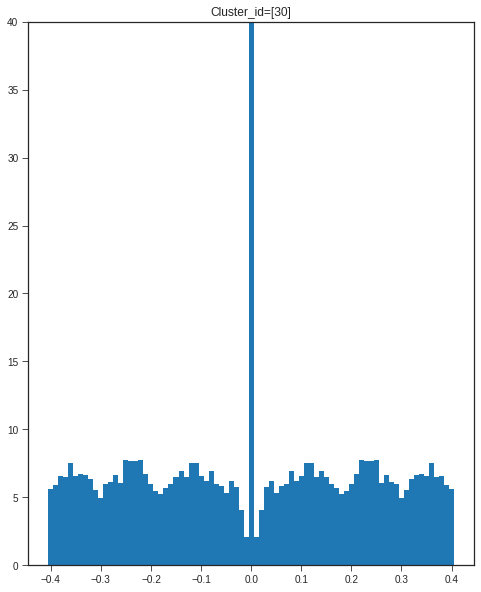

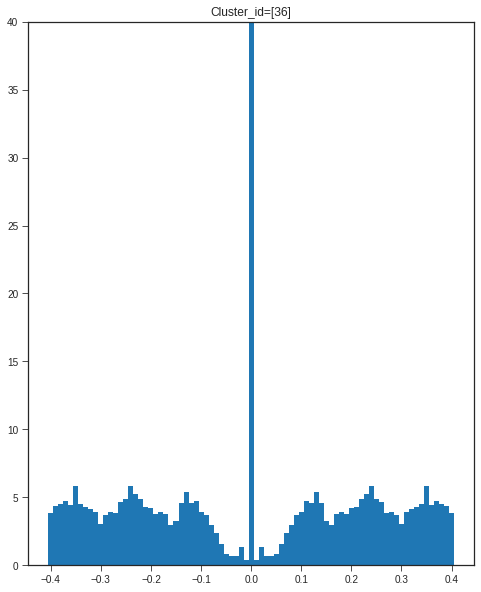

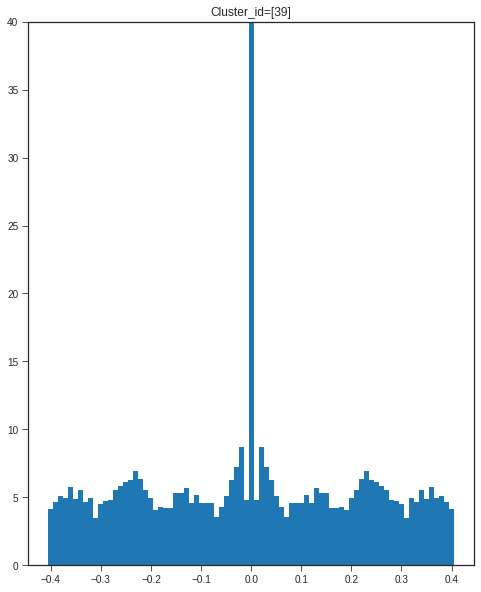

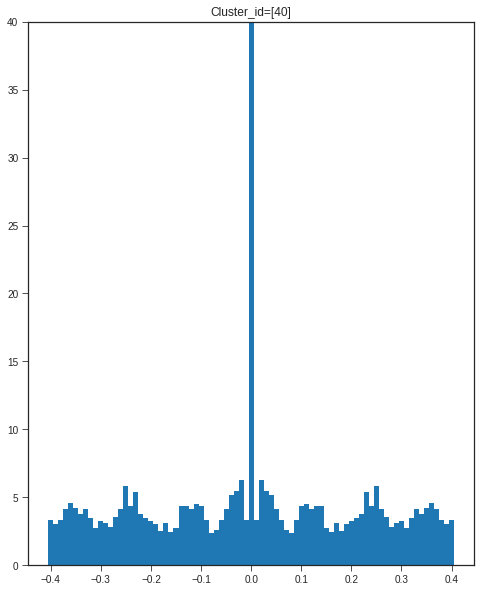

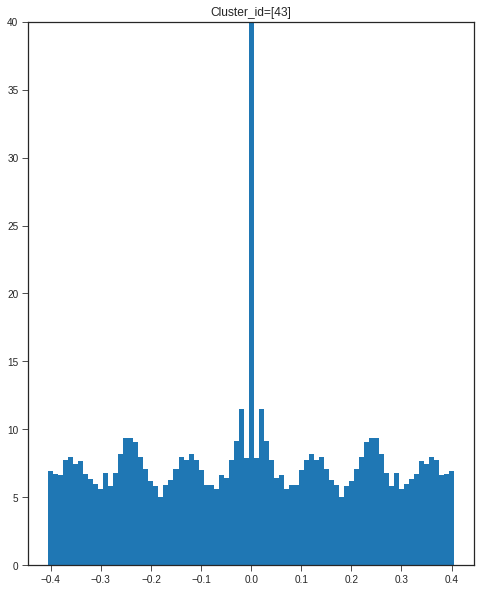

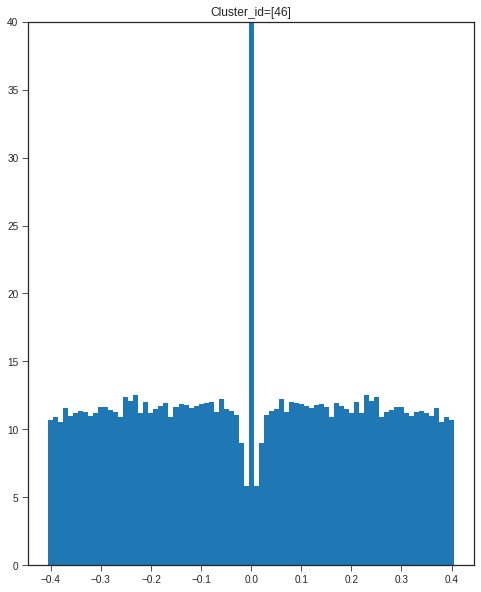

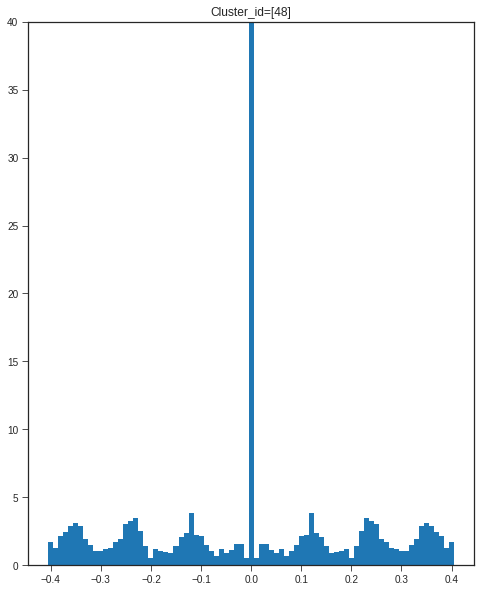

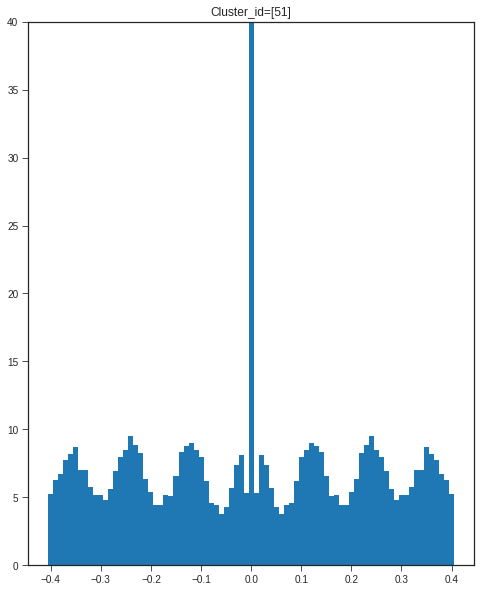

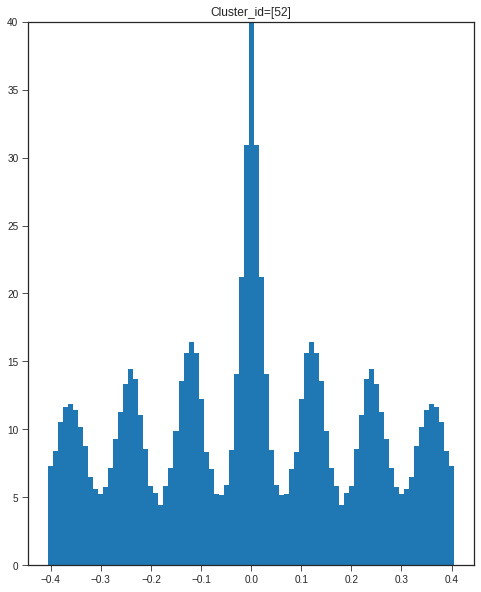

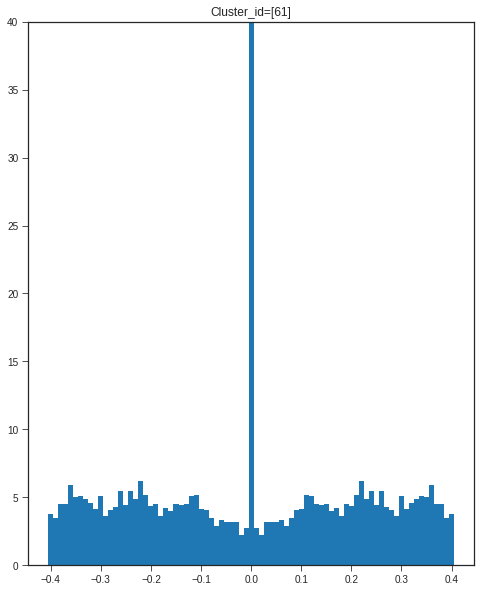

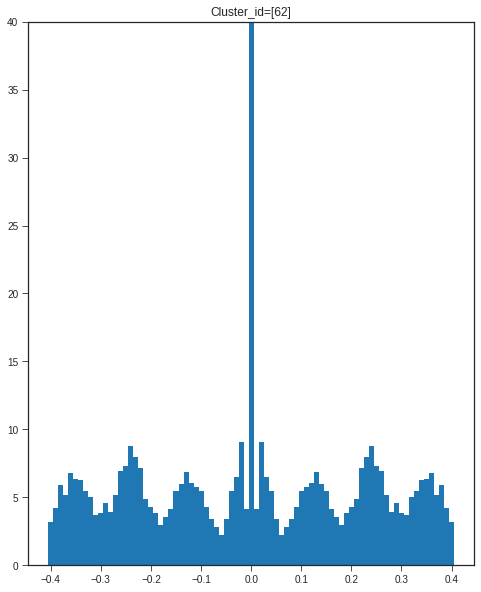

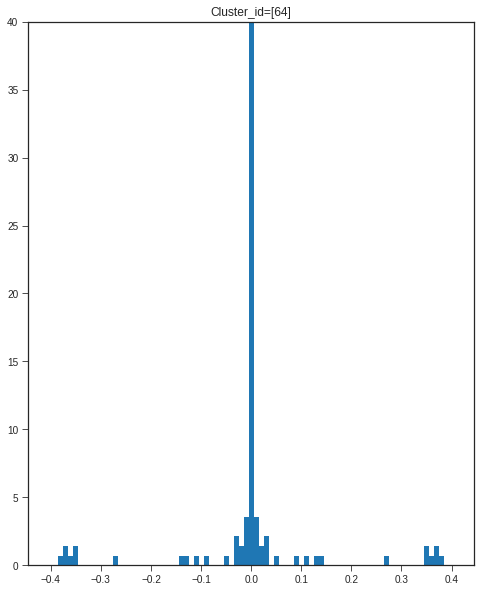

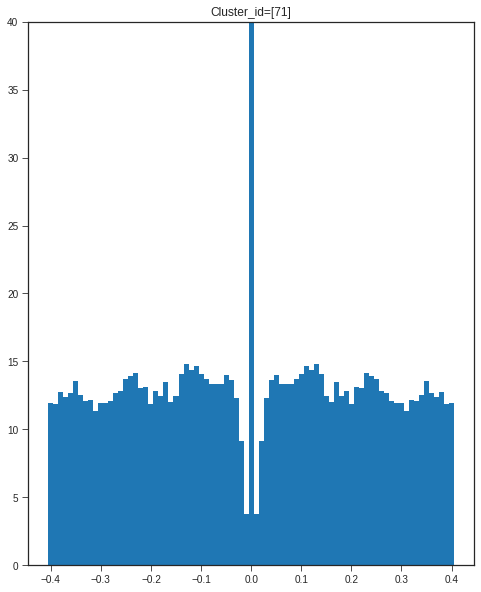

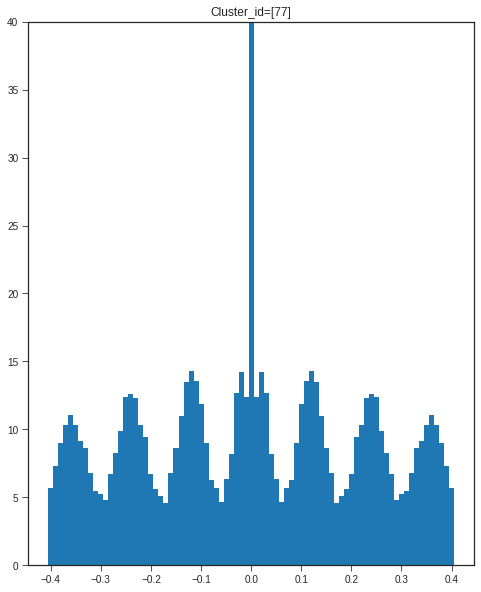

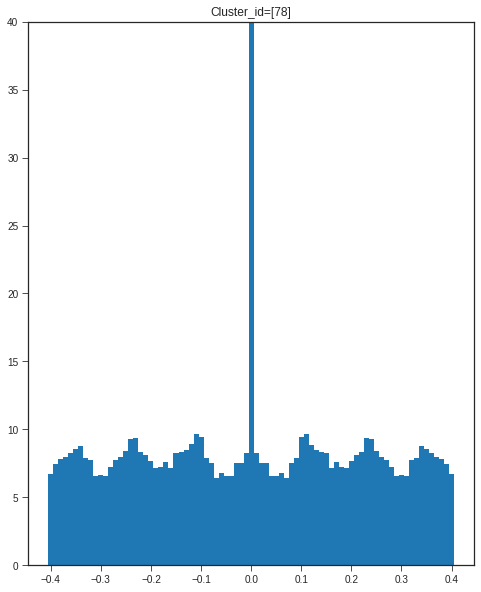

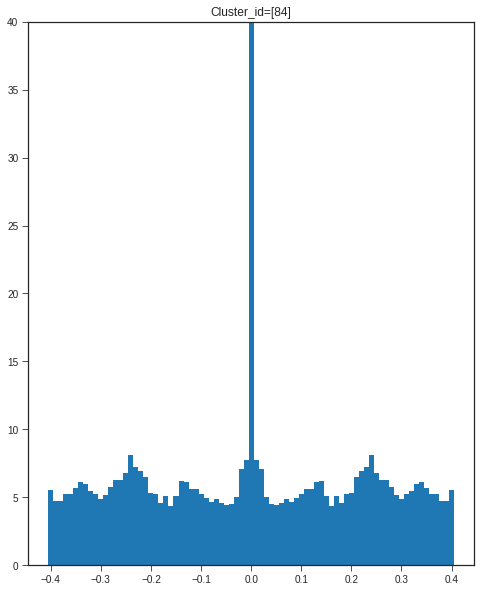

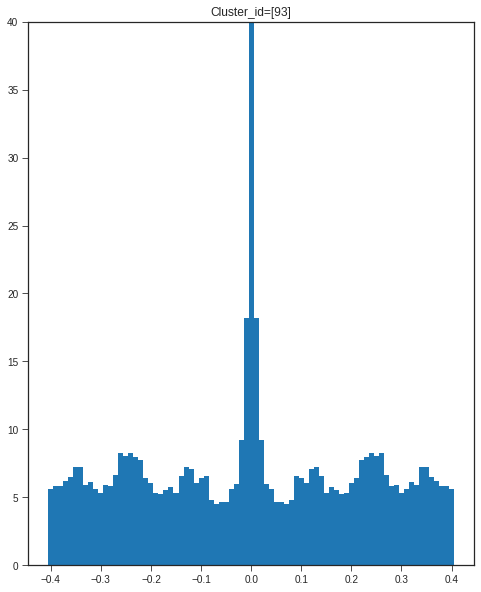

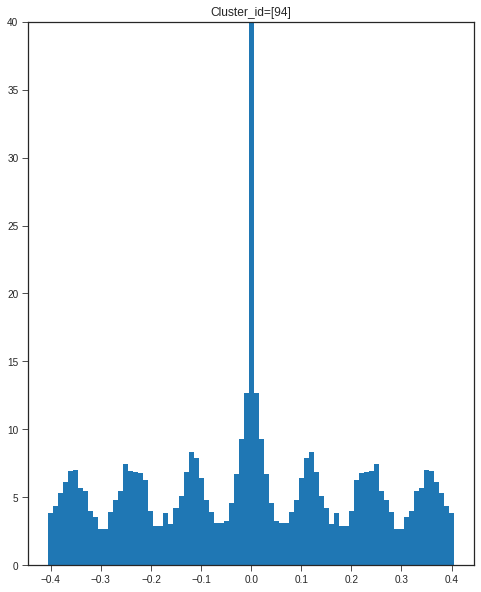

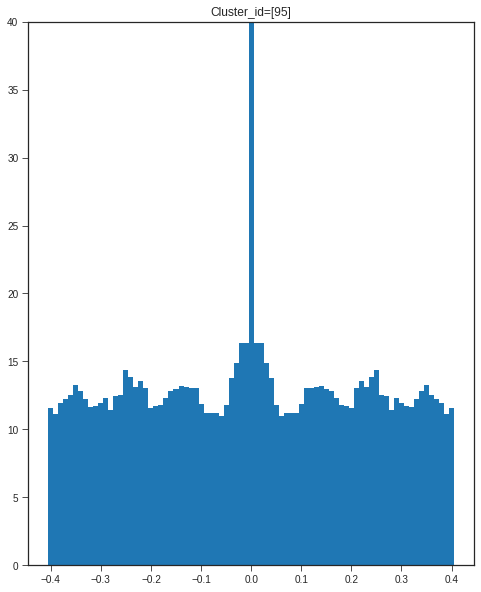

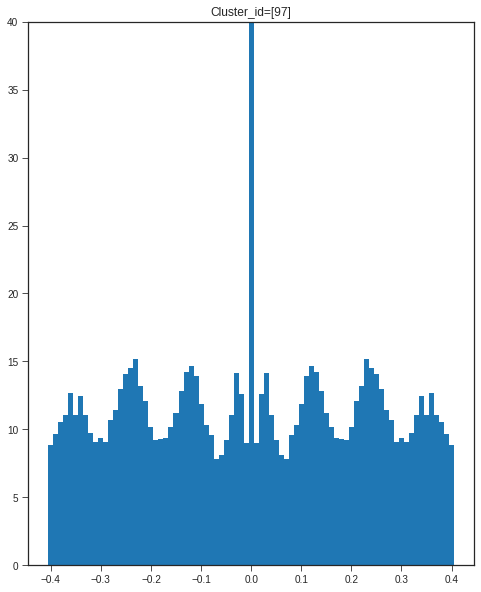

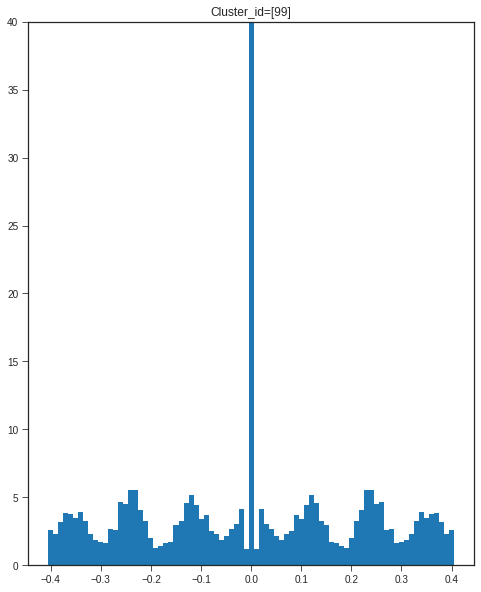

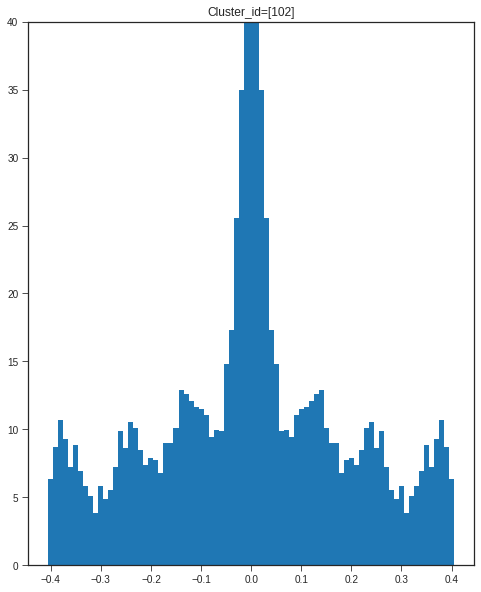

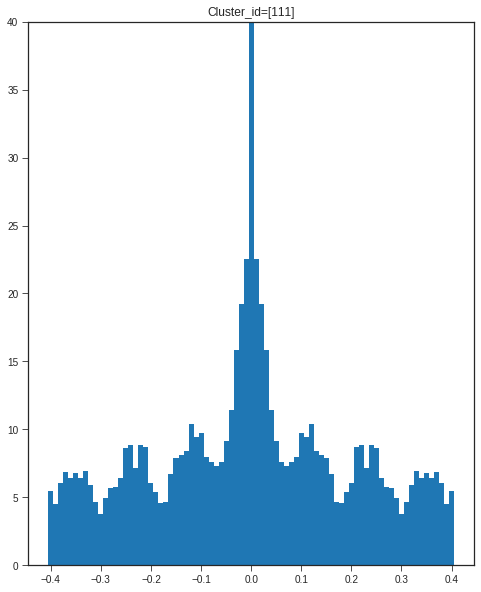

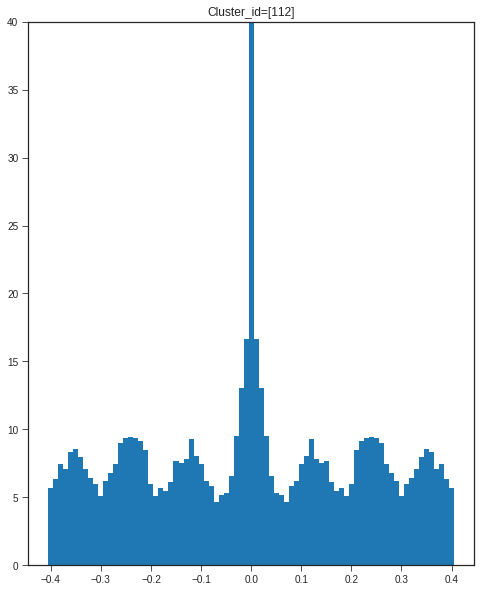

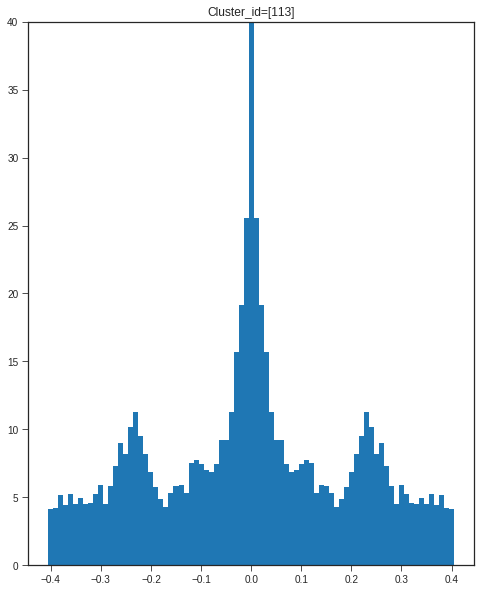

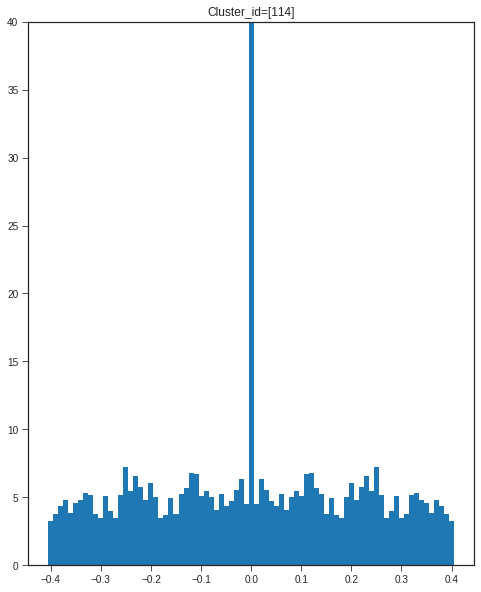

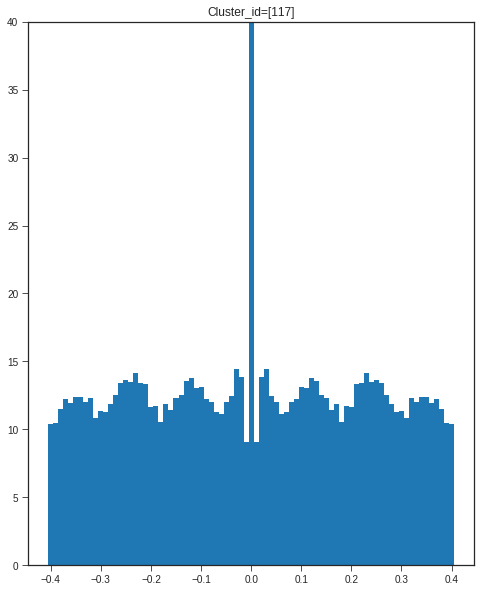

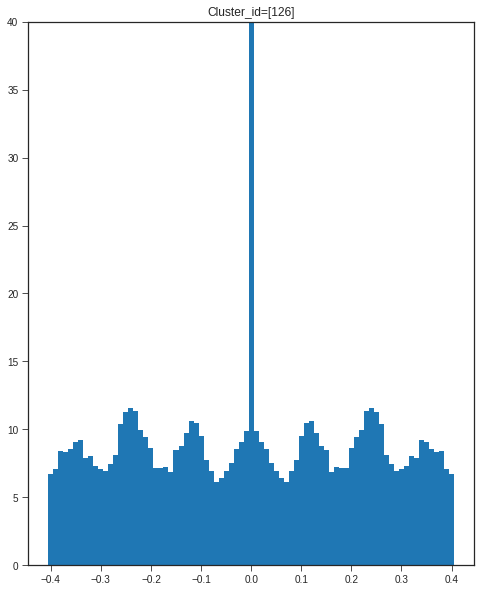

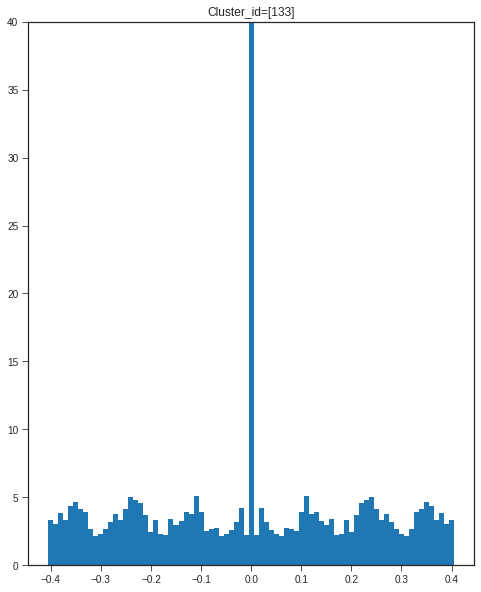

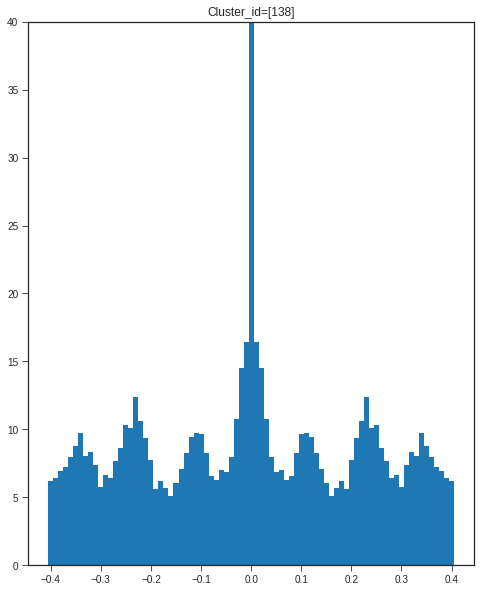

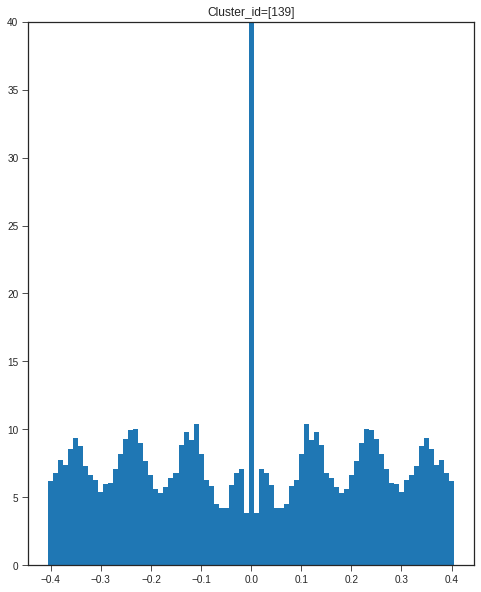

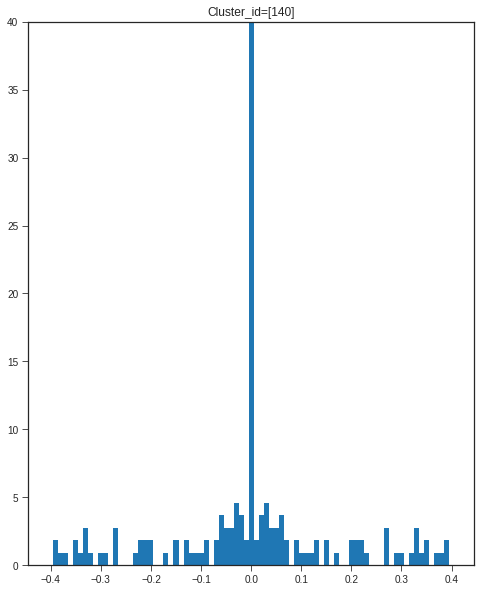

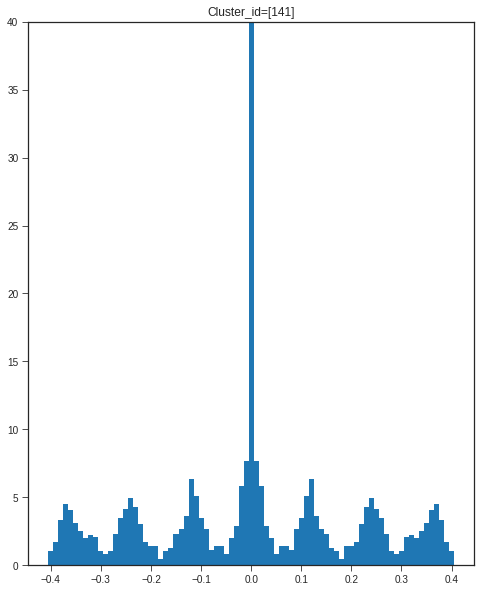

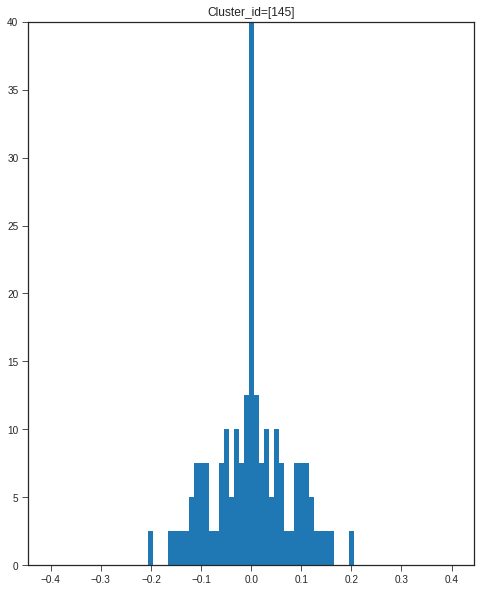

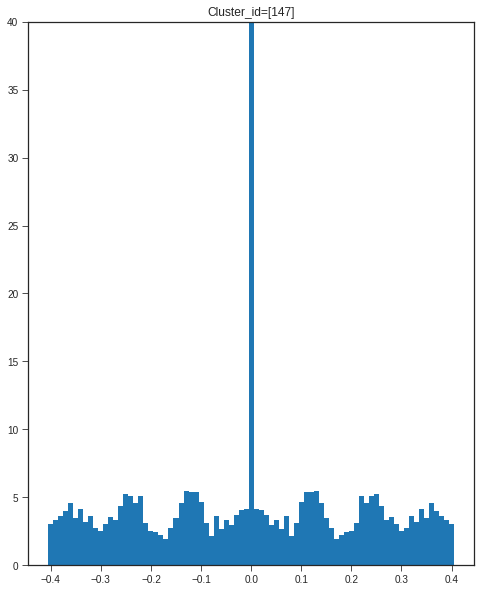

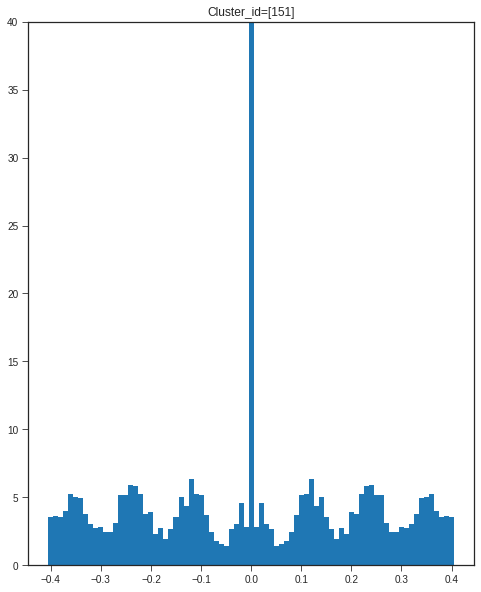

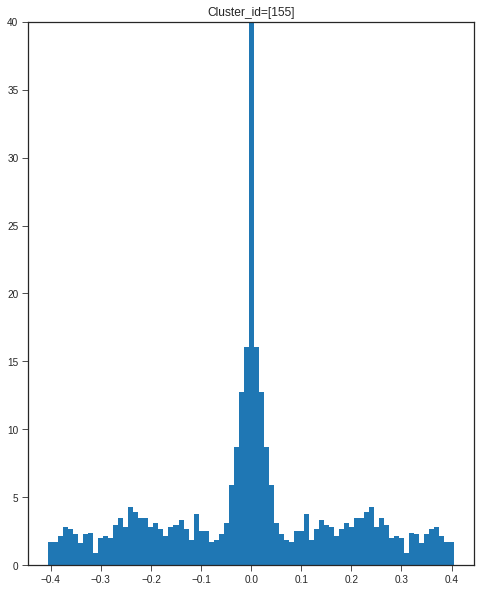

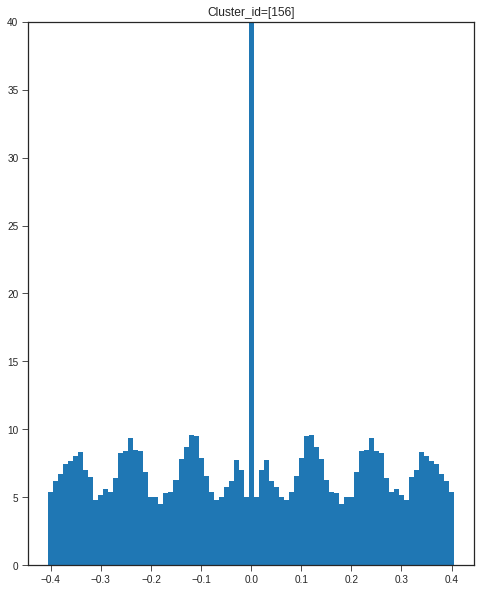

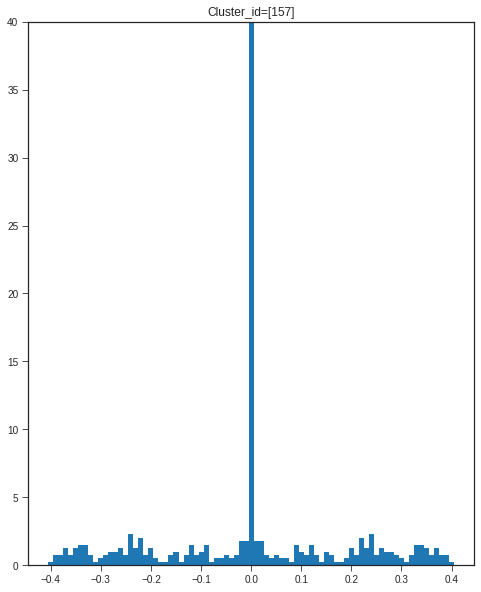

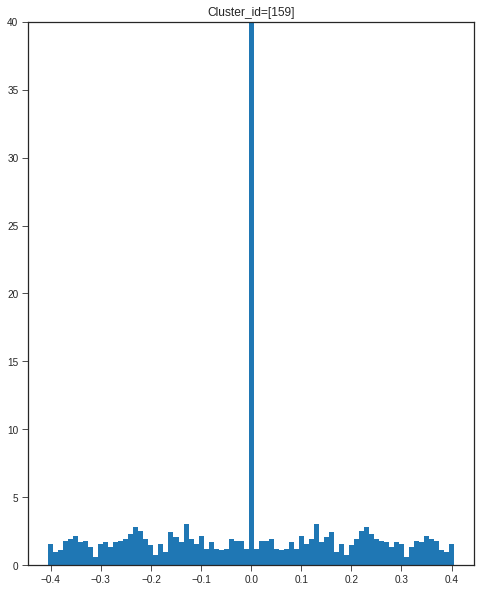

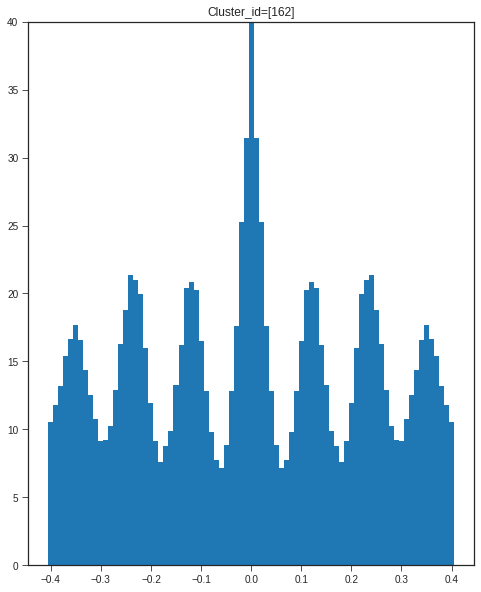

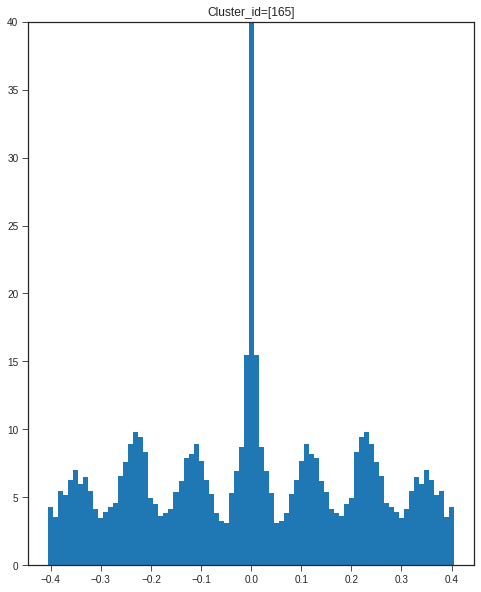

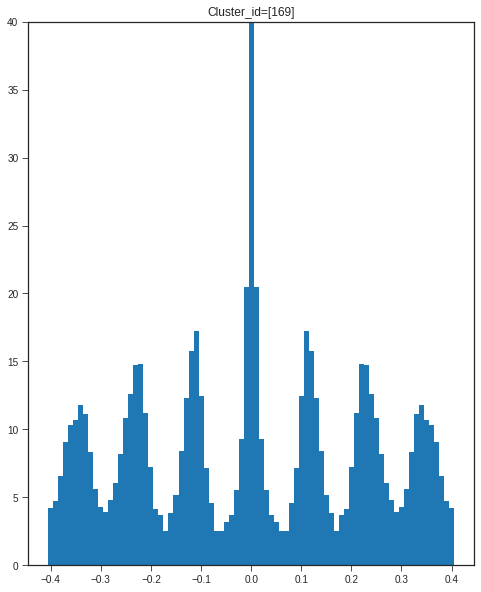

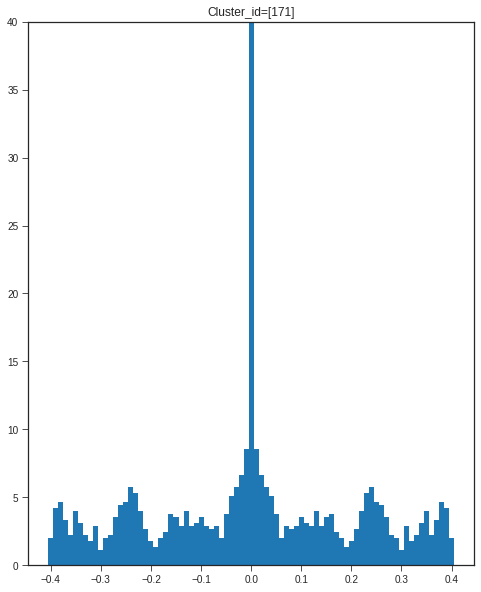

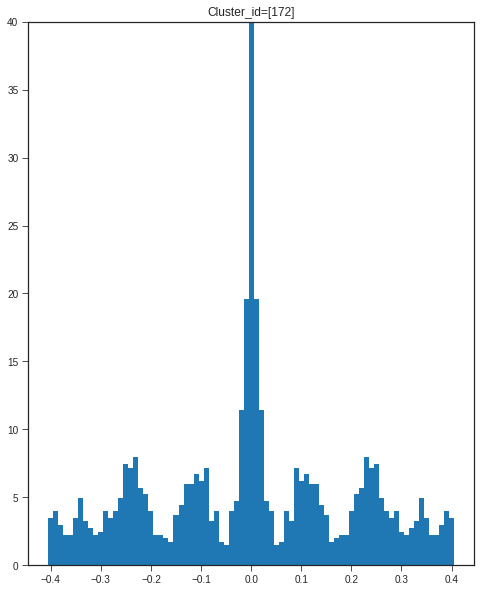

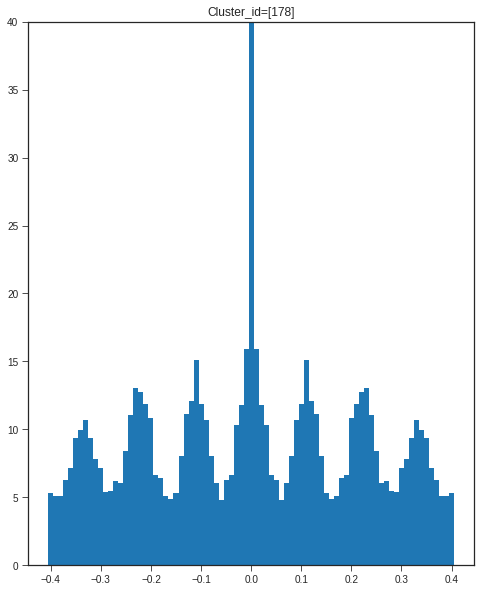

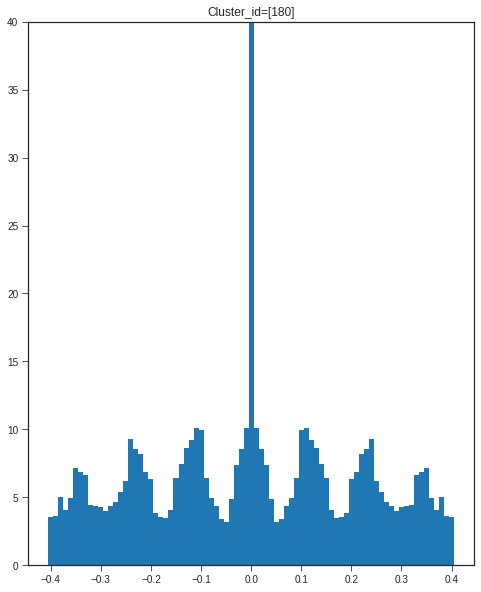

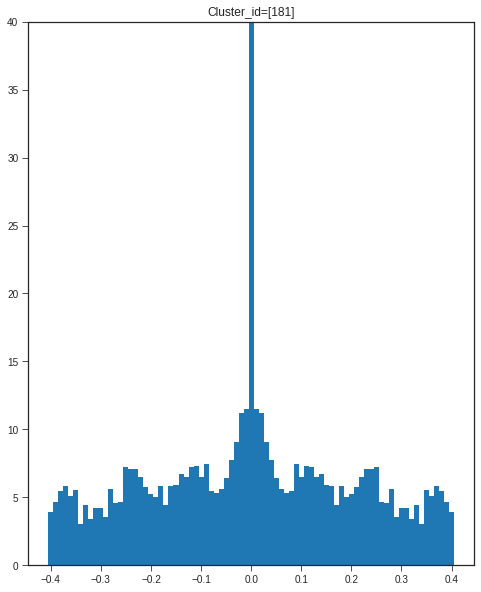

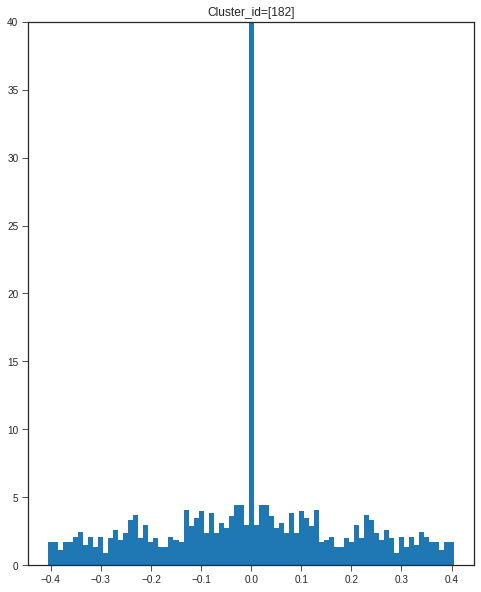

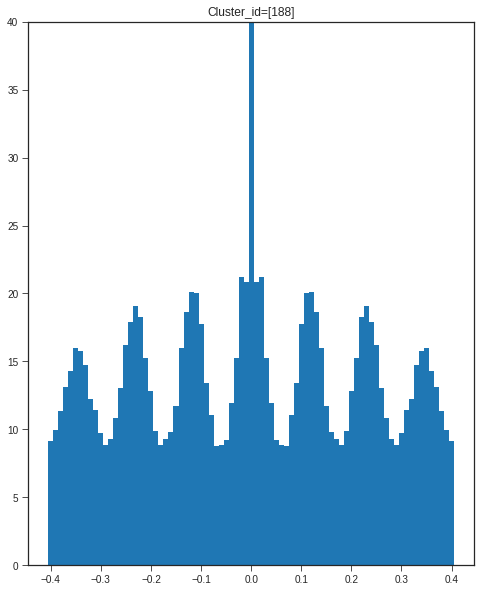

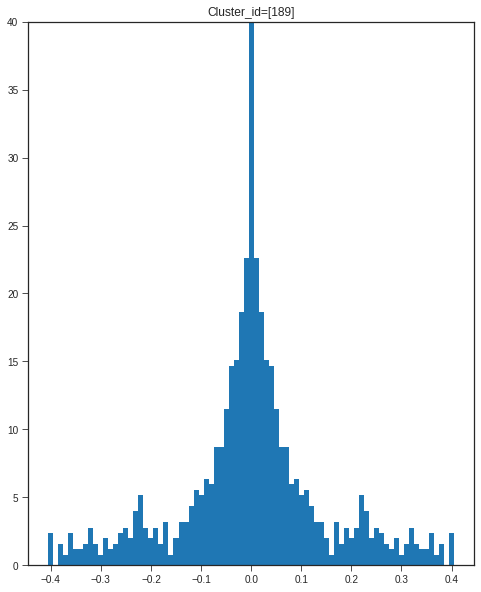

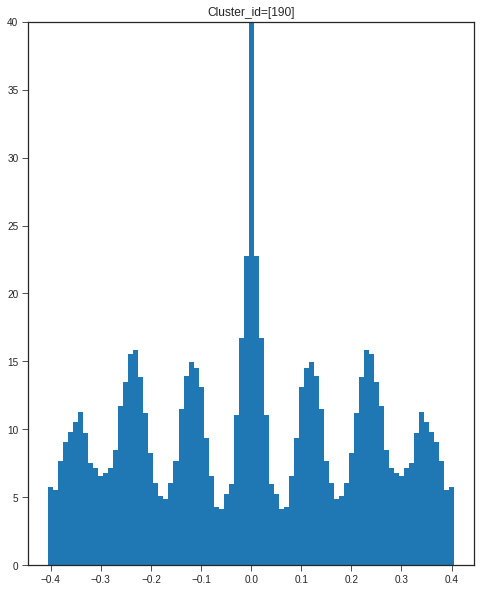

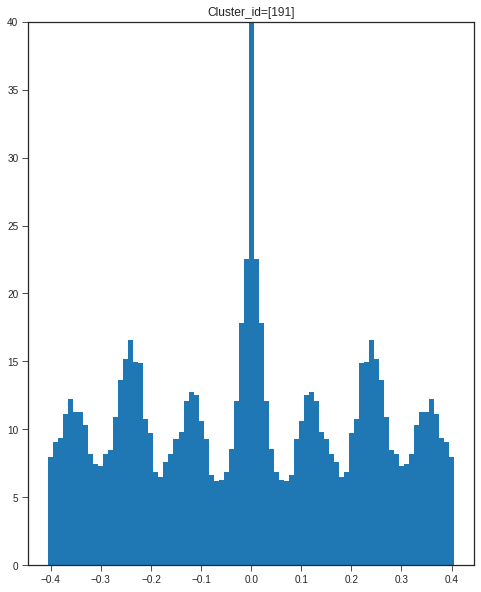

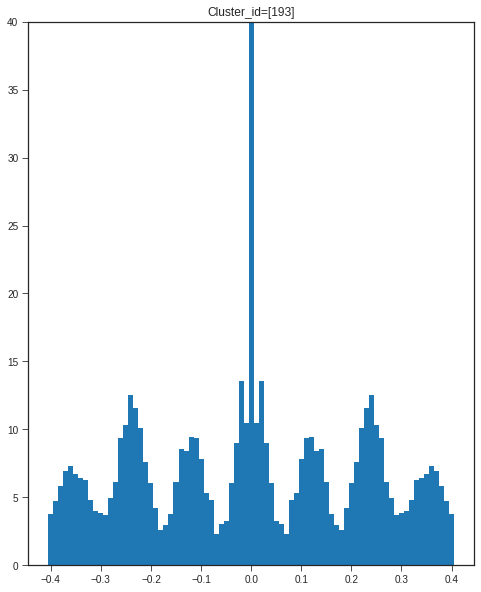

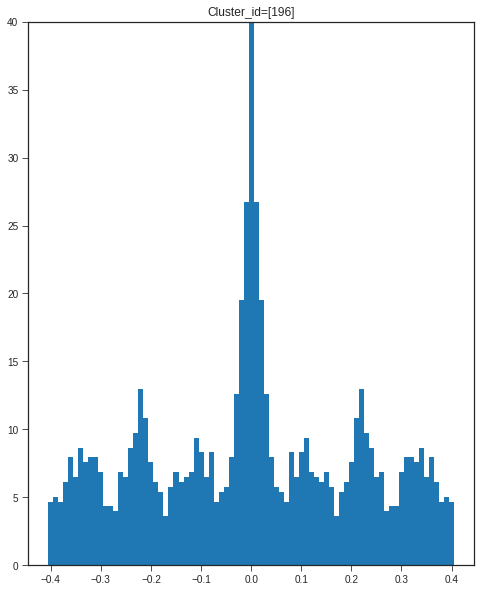

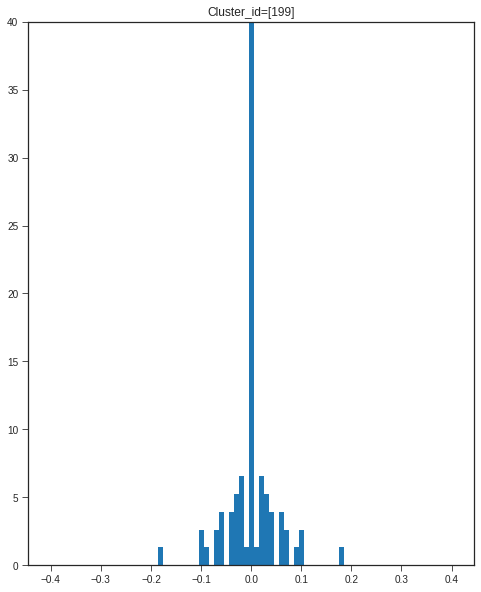

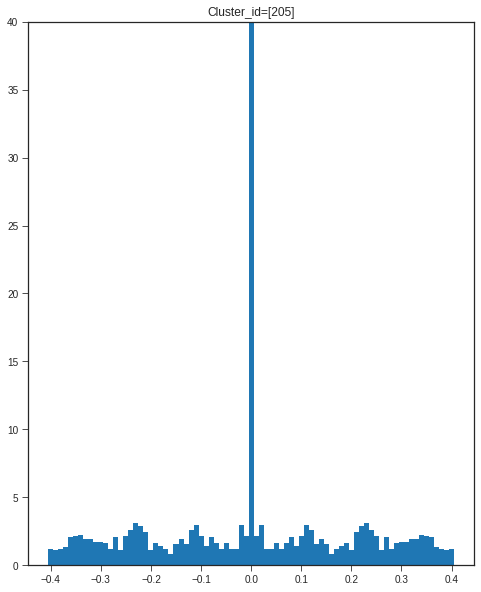

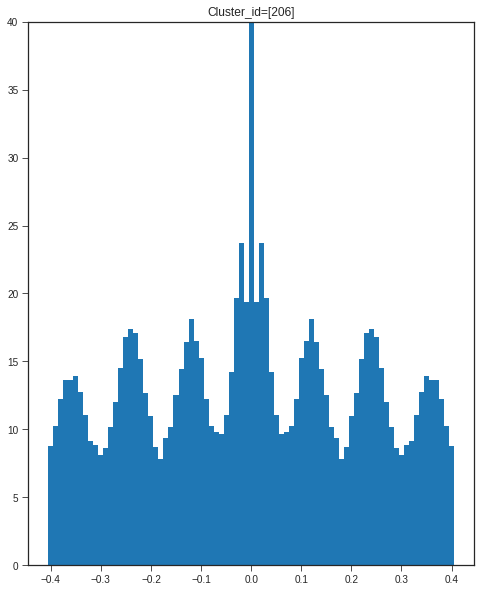

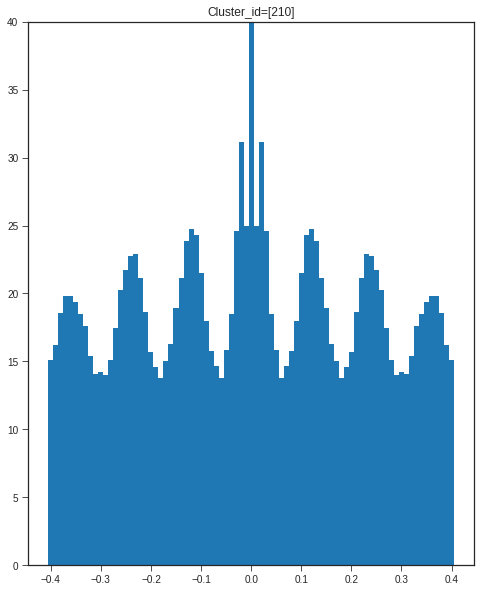

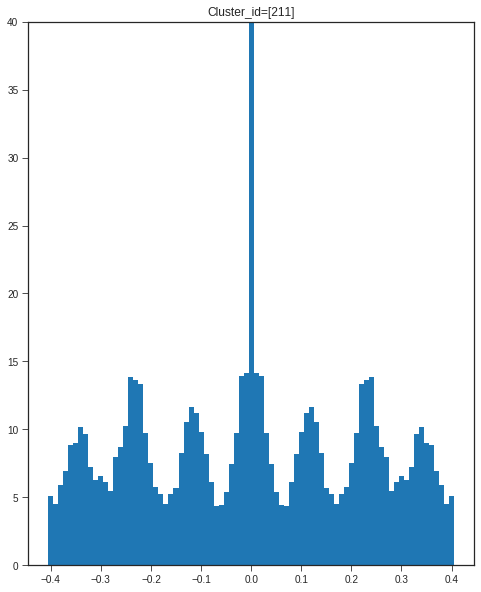

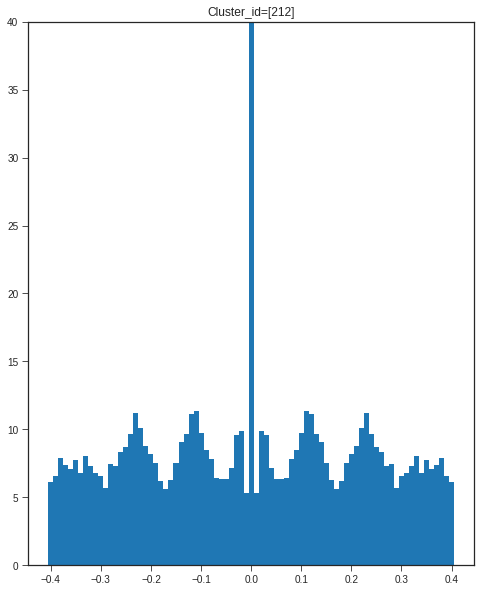

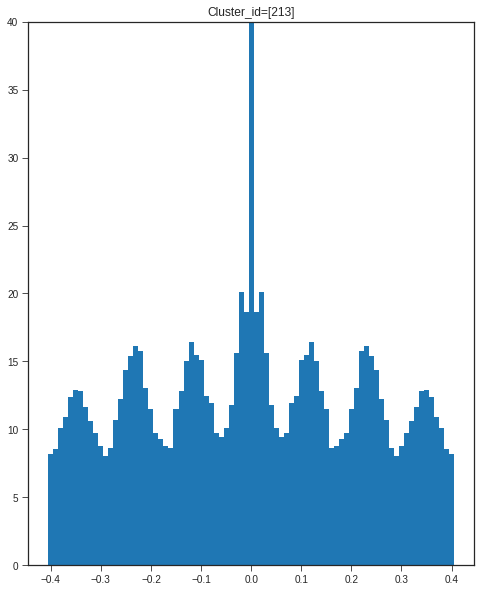

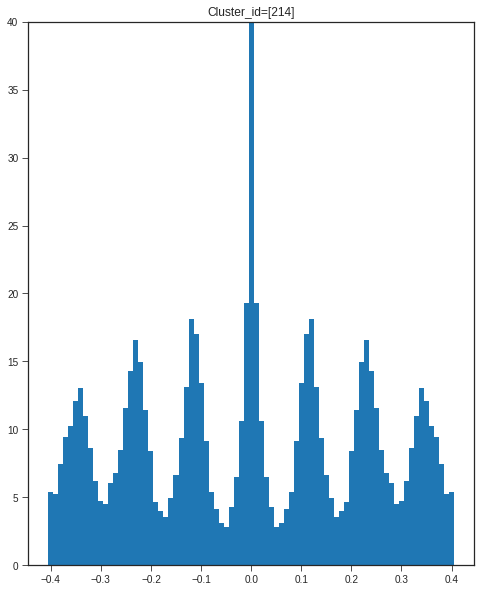

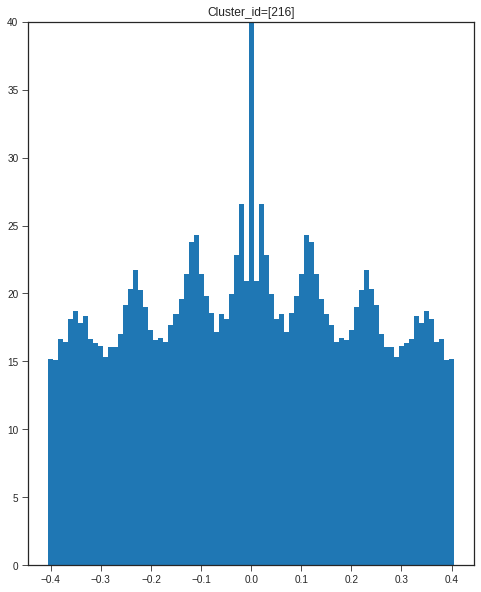

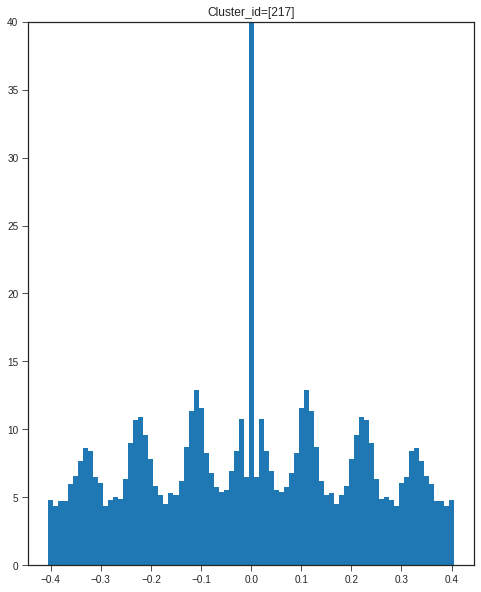

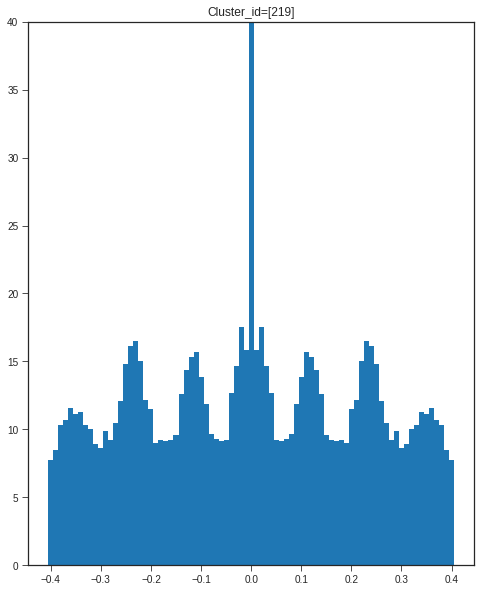

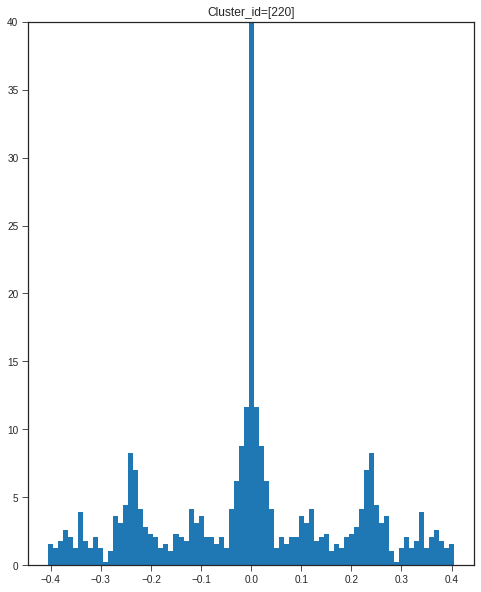

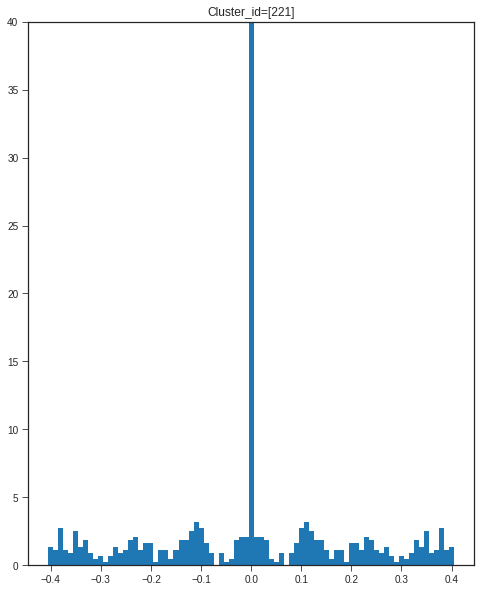

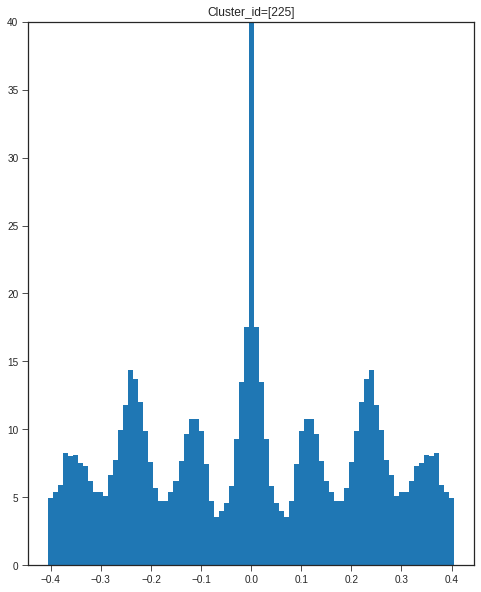

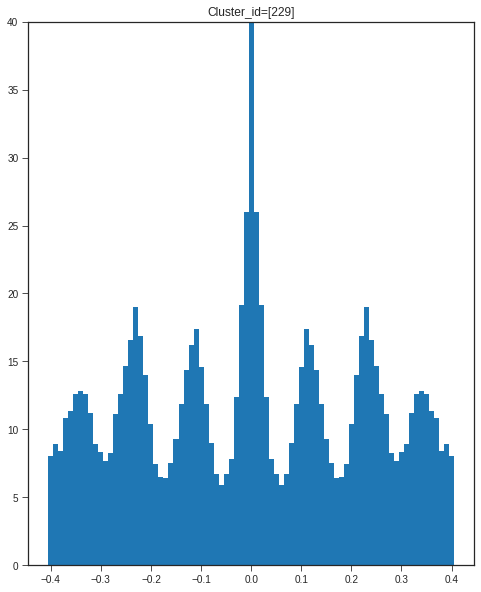

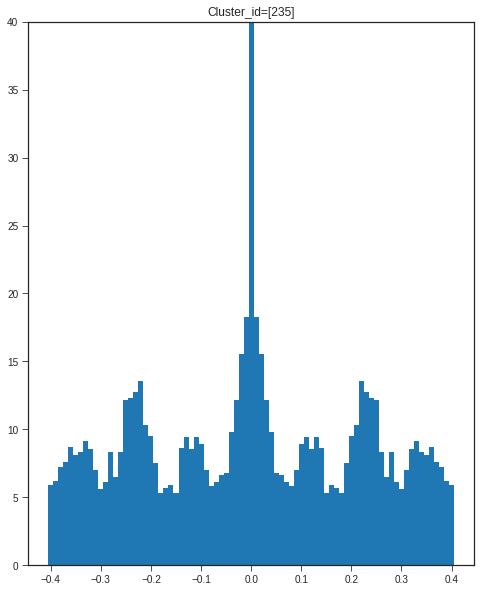

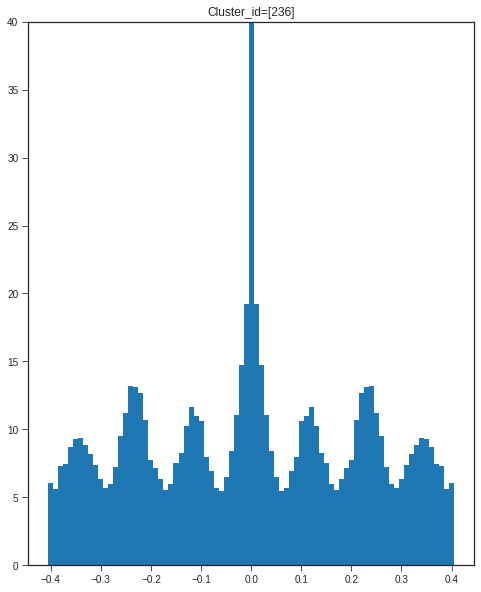

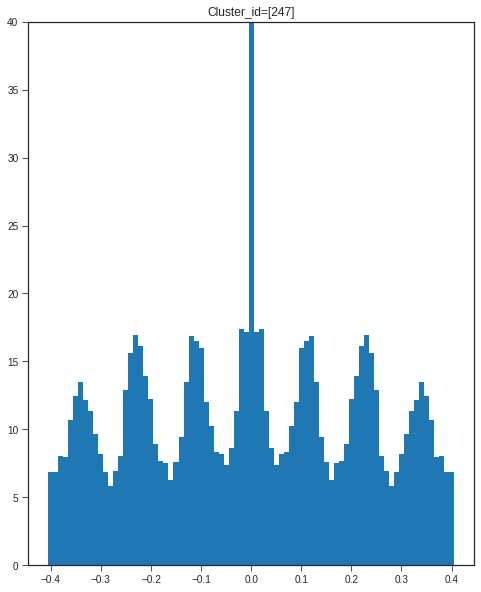

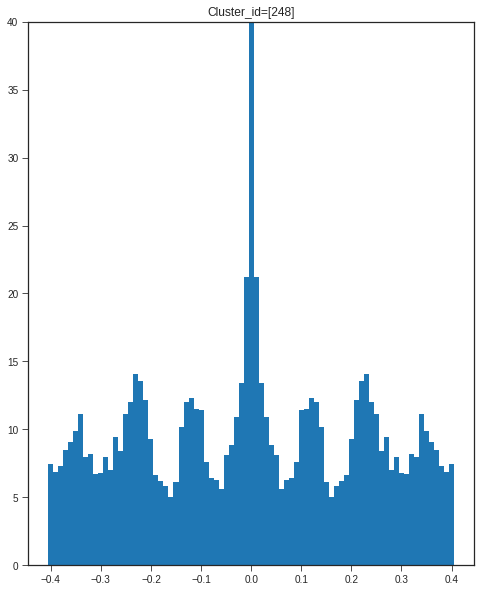

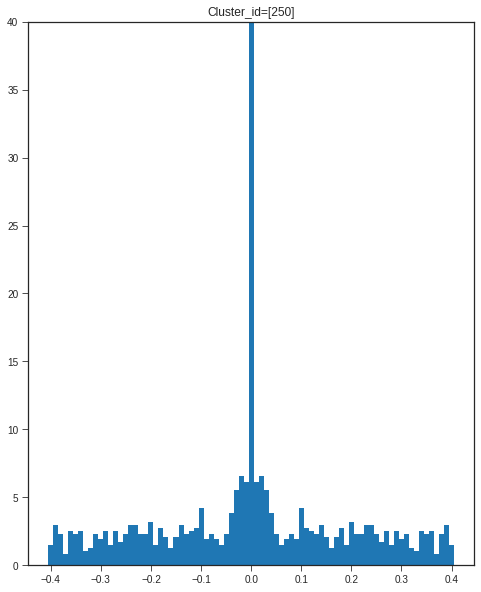

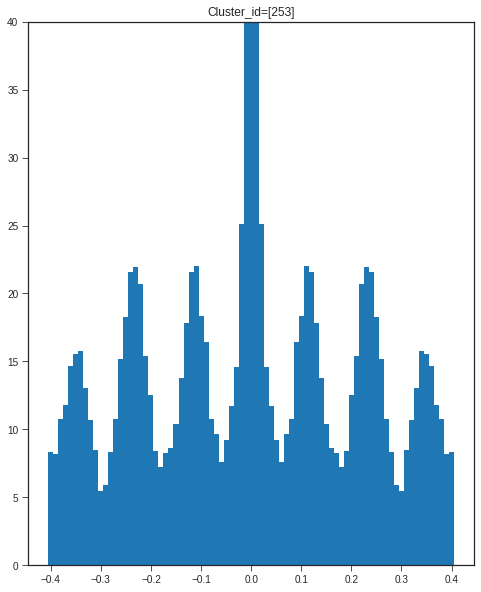

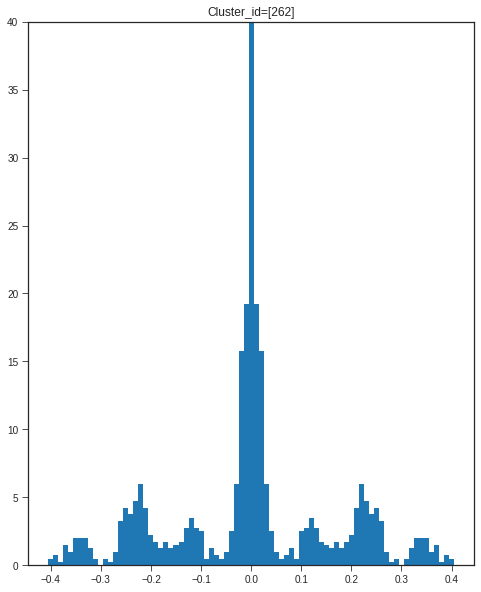

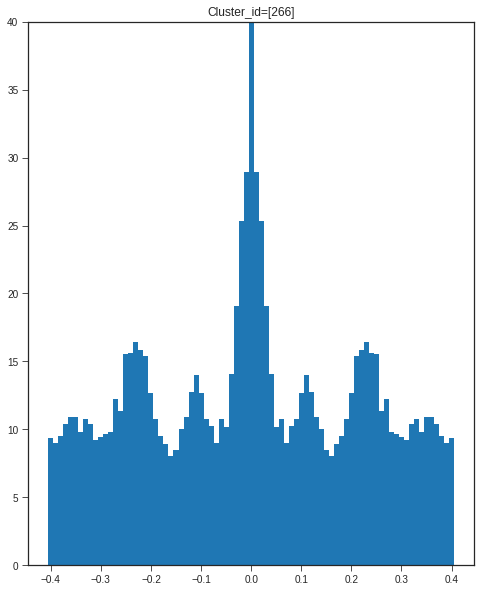

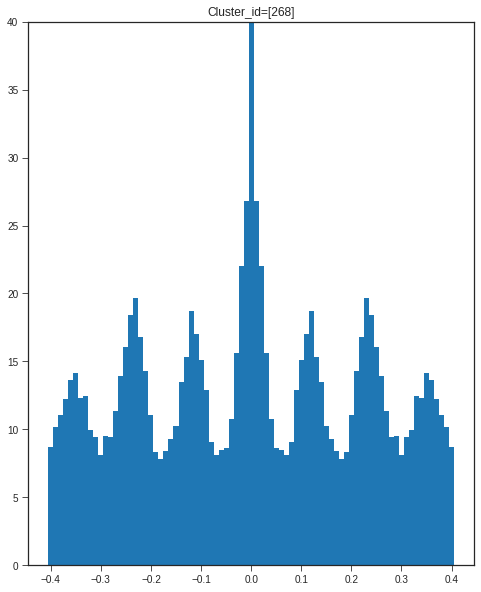

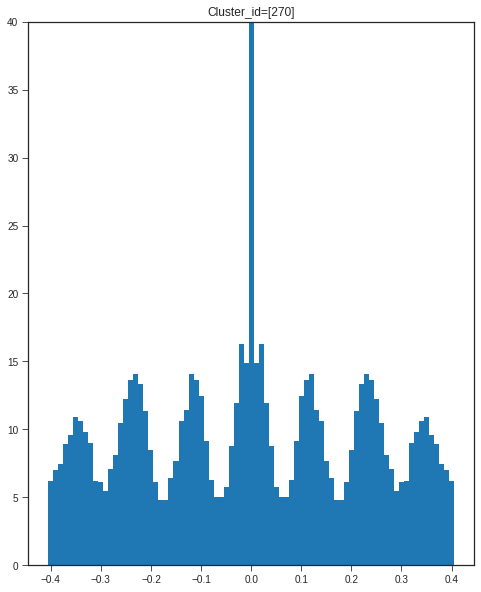

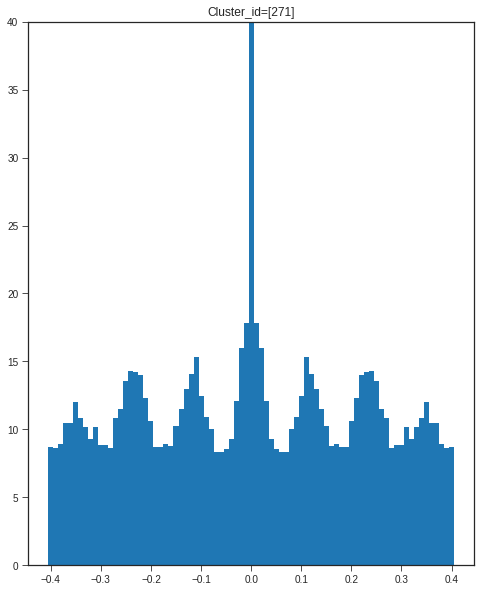

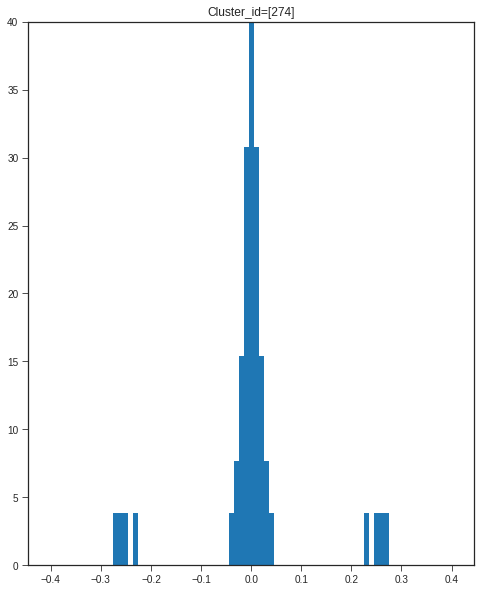

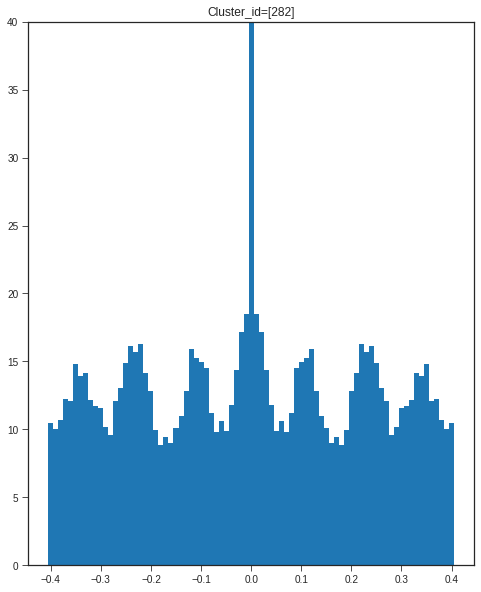

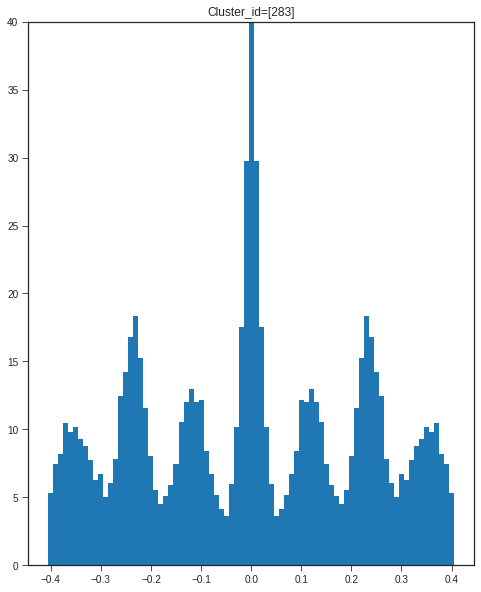

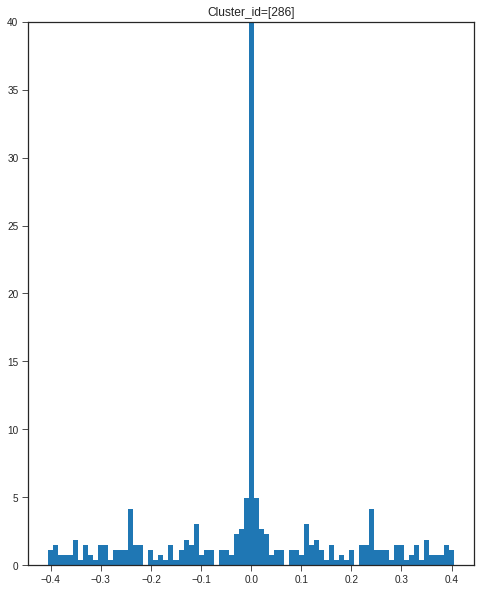

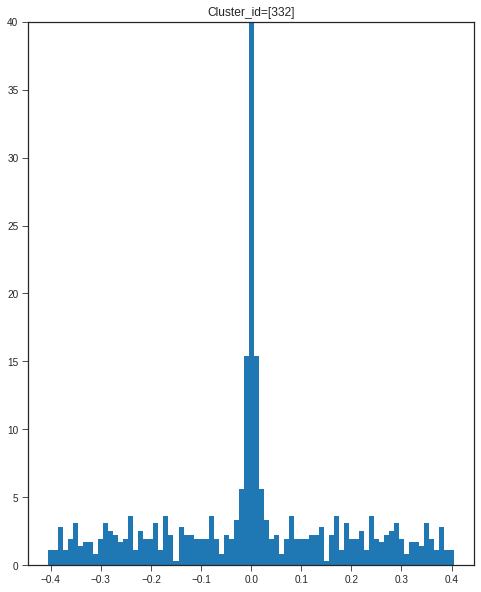

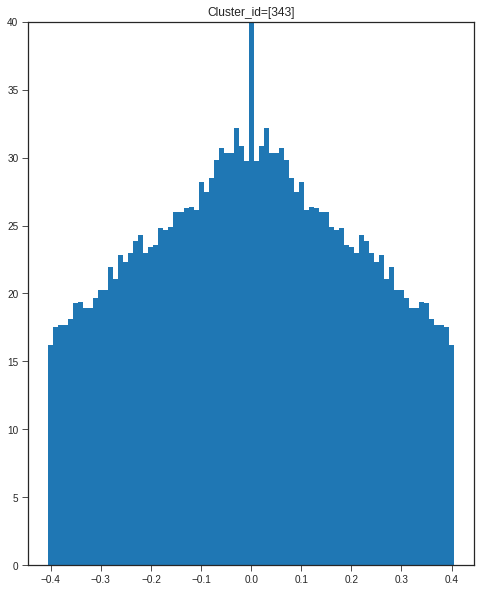

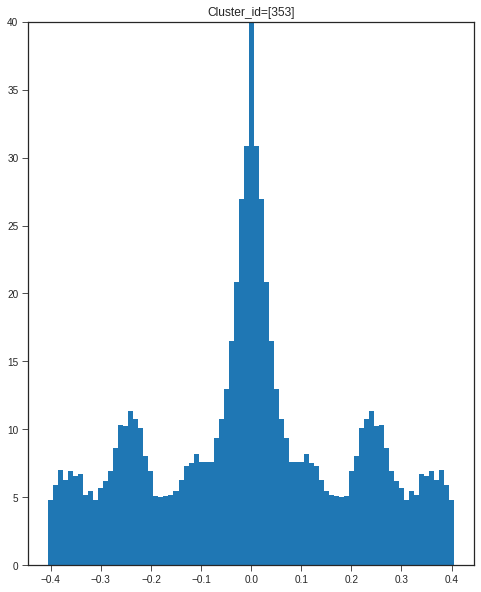

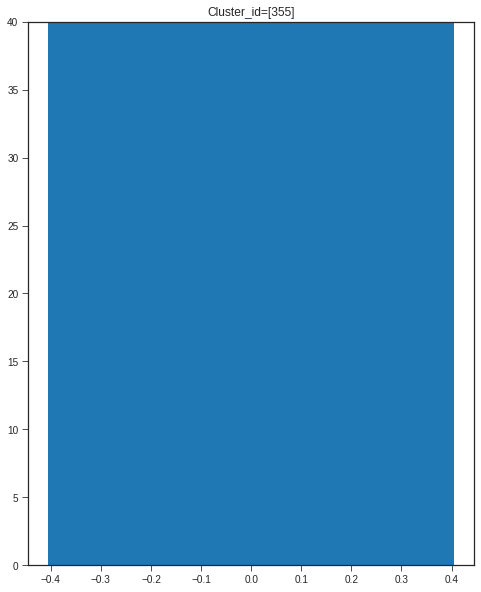

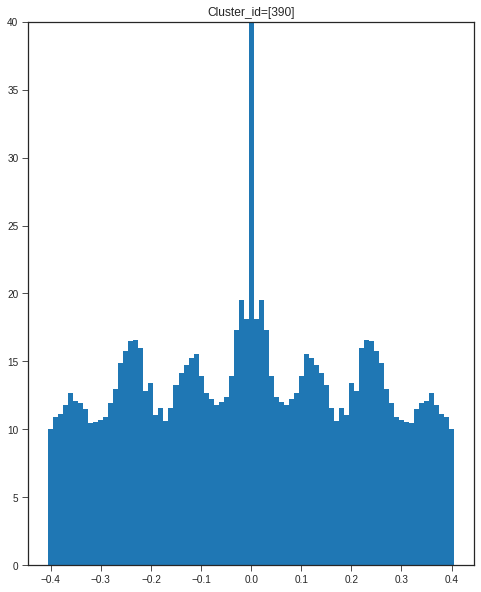

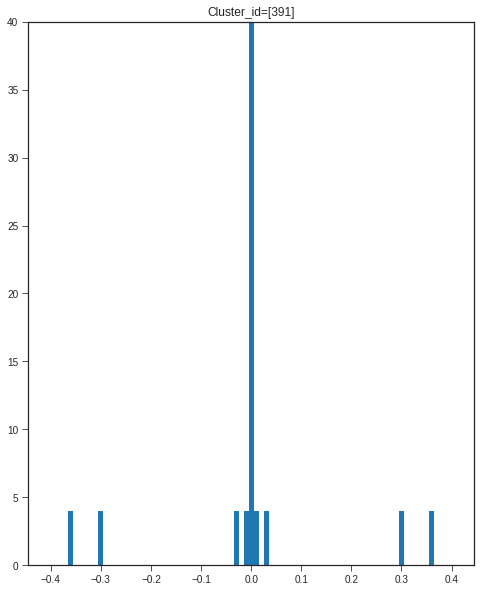

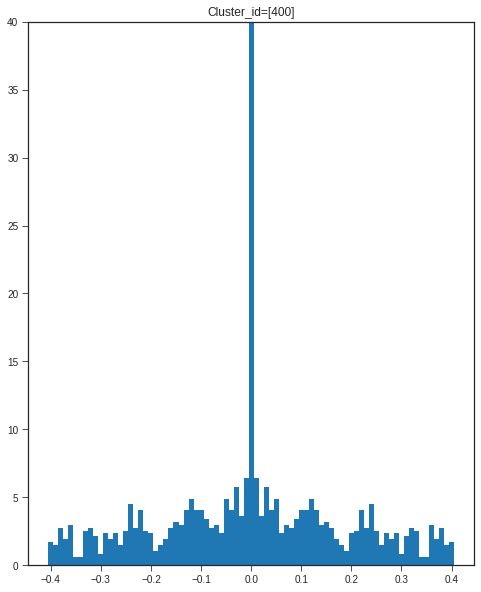

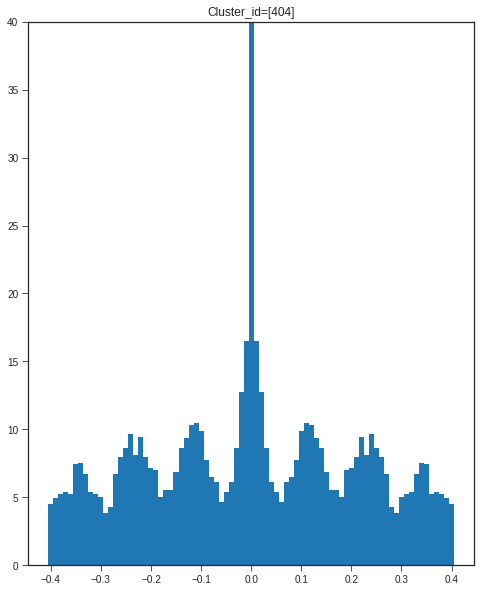

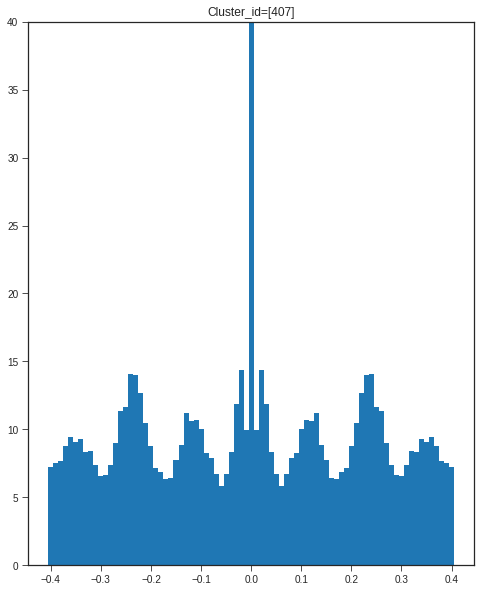

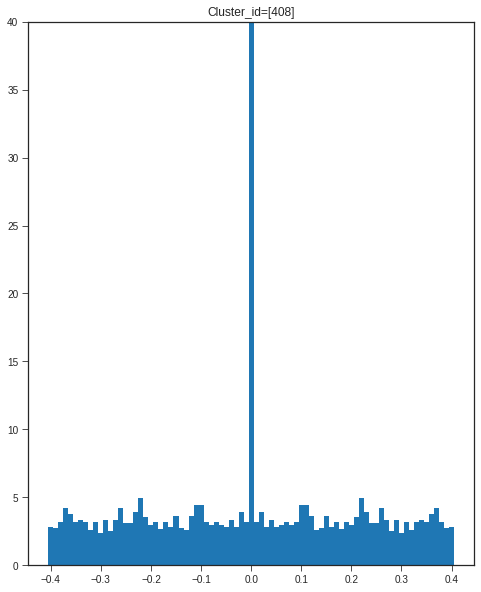

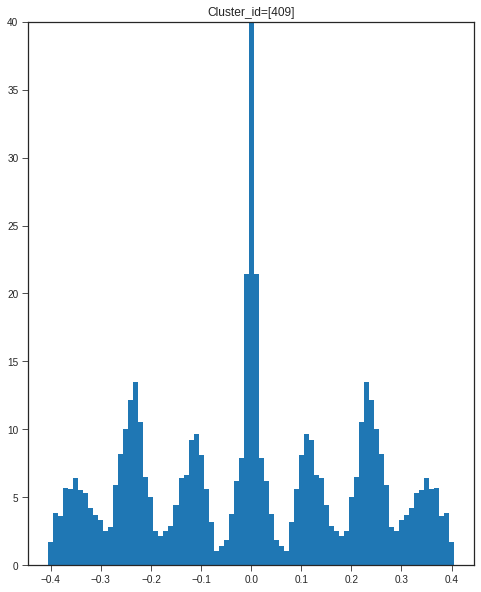

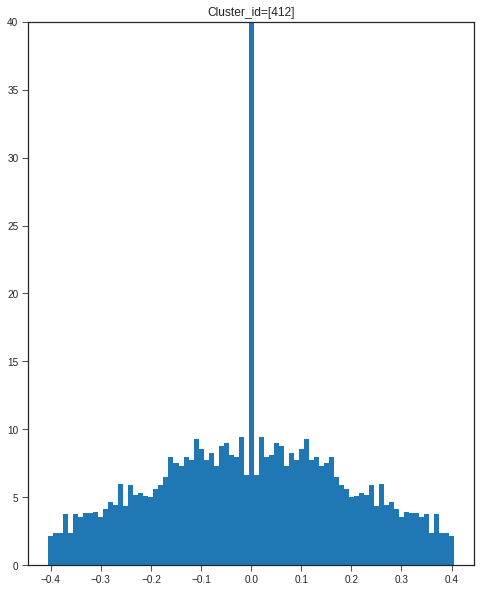

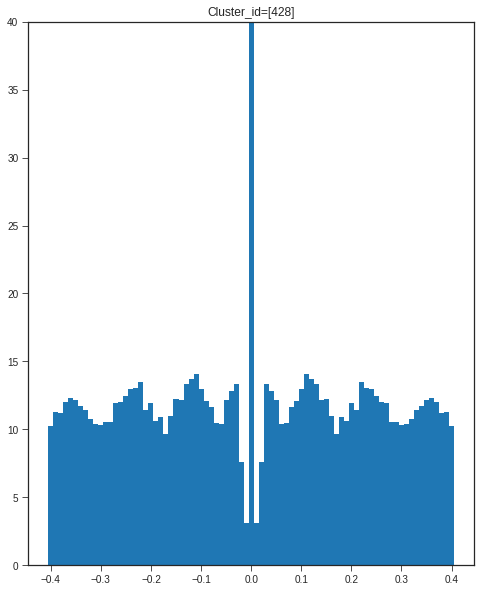

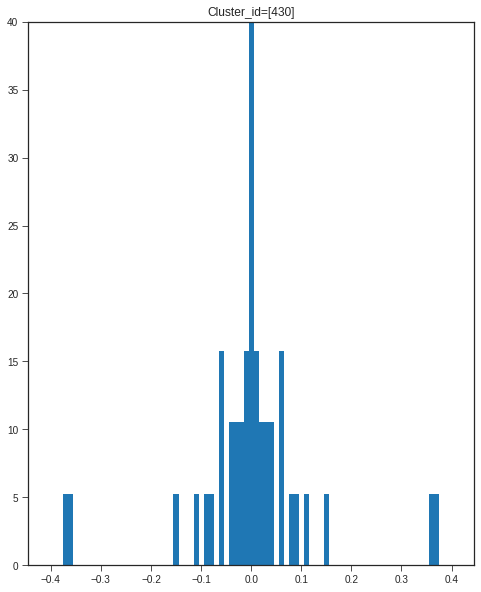

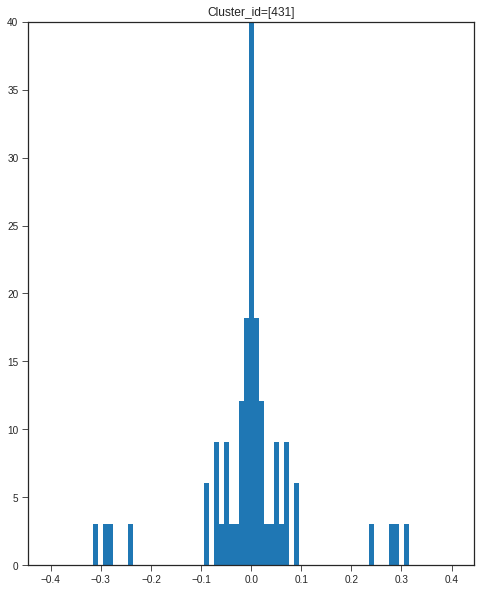

In [17]:
for cl in cluster_ids:
    histogram, bins = peri_event_histogram(spike_t[cl], segments=out_in,lags = np.linspace(-0.405, 0.405, 82), normalization='rate')
    plt.figure()
    plt.bar(bins[:,0], histogram[:,0,0], width=bins[:,1]-bins[:,0], align='edge', label=cl)
    plt.ylim(0,40)
    plt.title('Cluster_id=' + str([cl])) 
    #plt.savefig('/home/kasia/K/Neuropixeldata/LS_K_7/theta_choicepoint/all.png')
    plt.savefig('/mnt/fk-fileserver/Project_LS/LS_k_7/310720/ACG_outandin/ACG'+str([cl])+'.png')
    plt.show()

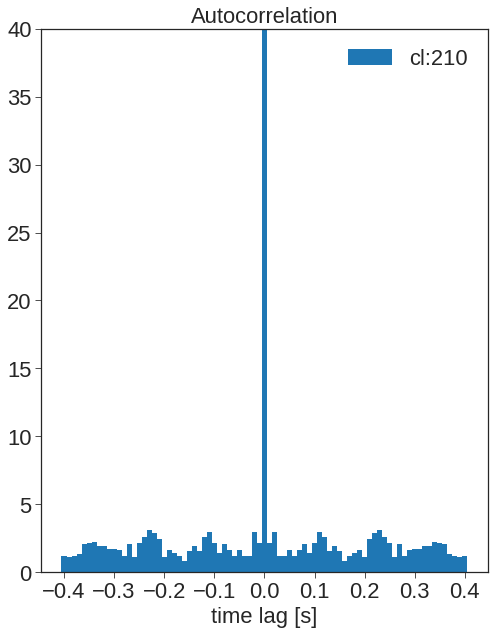

In [142]:
from fklab.events.basic_algorithms import peri_event_histogram
histogram, bins = peri_event_histogram(spike_t[205], segments=out_in,lags = np.linspace(-0.405, 0.405, 82), normalization='rate')
plt.figure()
plt.bar(bins[:,0], histogram[:,0,0], width=bins[:,1]-bins[:,0], align='edge', label='cl:210')
plt.ylim(0,40)
plt.title('Autocorrelation',fontsize=22) 
    #plt.savefig('/home/kasia/K/Neuropixeldata/LS_K_7/theta_choicepoint/all.png')
    #plt.savefig('/home/kasia/K/Neuropixeldata/LS_K_7/theta_inbound_right/theta'+str([cl])+'.png')
plt.xlabel('time lag [s]', fontsize=22)
#ax.set_ylabel('Power spectral density [mV*mv/Hz] in dB', fontsize=14)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)
plt.legend(fontsize=22)
plt.show()

### Calculate the theta modulation for all the clusters

## Theta modulation function

In [125]:
def shuffle_spike_train (spike_t, bandwidth=0.0425):
    shuffled_spikes = spike_t + np.random.normal(scale=bandwidth, size=spike_t.shape)
    shuffled_spikes = np.sort(shuffled_spikes)
    
    return (shuffled_spikes)

In [135]:
s_spikes = shuffle_spike_train(spike_t[408])

In [149]:
def theta_modulation (spike_t, segments, bin_size=0.001, window_size =2, bandwidth =1, theta_band=[6,10], freq_band=[1,50], **kwargs):
    #determine start and end times
    start, end = spike_t[0] - 0.5 * bin_size, spike_t[-1] + 0.5 * bin_size
    #bin spike times
    bins = fklab.segments.check_segments(np.arange(start, end, bin_size))
    spikes_binned = fklab.events.basic_algorithms.fastbin(spike_t, bins)

    #compute spectrum
    psd, f, _, _ = mt.mtspectrum(
        spikes_binned.ravel(),
        fs=1.0 / bin_size,
        window_size=window_size,
        bandwidth=bandwidth,
        start_time=spike_t[0],
        fpass=freq_band,
        epochs=segments,
    )

    #compute power in frequency bands
    # Find intersecting values in frequency vector
    idx_theta = np.logical_and(f >= theta_band[0], f <= theta_band[1])
    idx_total = np.logical_and(f >= freq_band[0], f <= freq_band[1])
    
    #find the frequency resolution
    freq_res = f[1] - f[0] 
    
    #compute theta relative power 
        # Compute the absolute power for theta band
    theta_power = simps(psd[idx_theta], dx=freq_res)
        # Compute the absolute power in specified power bands
    total_power = simps(psd[idx_total], dx=freq_res)
        # Compute relative power 
    theta_rel_power = theta_power / total_power
    
    return(psd, f, theta_power, total_power, theta_rel_power)

In [143]:
from scipy.integrate import simps
psd, f, tpower, totpower, mod = theta_modulation(spike_t[205], segments=out_in)

In [144]:
mod

0.08839715678545824

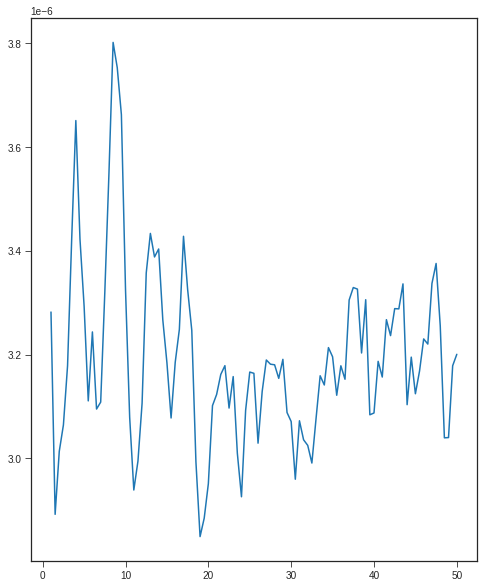

In [145]:
plt.plot(f, psd)

In [151]:
results_mod = {}
nshuffles = 500
for cl in cluster_ids:
    spikes = spike_t[cl]
    psd, f, tpower, totpower, mod = theta_modulation(spikes, segments=outbound)
    
    shuffled_results=[]
    for n in range(nshuffles):
        shuffle_t = shuffle_spike_train(spikes)
        shuffled_results.append(theta_modulation(shuffle_t, segments=out_in))
        
        shuffled_power = np.array([x for _,_,_,_, x in shuffled_results])
    
        p = fklab.statistics.core.monte_carlo_pvalue(shuffled_power, mod)
    
    results_mod[cl] = {'modulation': mod, 'shuffles': shuffled_results, 'pvalue': p}

In [146]:
import pickle
from pathlib import Path
my_path = Path('/mnt/fk-fileserver/Project_LS/LS_k_7/300720/theta_mod_outandin')
with my_path.open('wb') as fp:
    pickle.dump(results_mod, fp)

In [76]:
r = np.array([[cl, k['modulation'], k['pvalue']] for cl,k in results_mod.items()])

In [98]:
theta_modulation = np.array([k['modulation'] for k in results_mod.values()])
mod_p = np.array([k['pvalue'] for k in results_mod.values()])

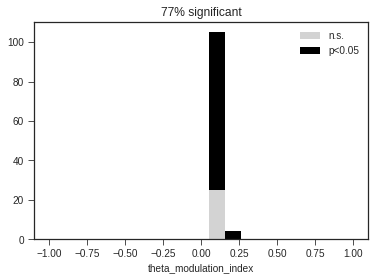

In [122]:
theta_modulation = np.array([k['modulation'] for k in results_mod.values()])
mod_p = np.array([k['pvalue'] for k in results_mod.values()])

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.hist([theta_modulation[mod_p>=0.01], theta_modulation[mod_p<0.01]], bins=np.linspace(-1,1,20), stacked=True, 
        color=['lightgray','black'], label=['n.s.', 'p<0.05'])
ax.legend()
ax.set(title="{:.0f}% significant".format(100*np.mean(mod_p<0.01)), xlabel="theta_modulation_index");

In [123]:
modulated_cl = r[r[:,2] < 0.01]
modulated_cl

array([[1.20000000e+01, 9.30361671e-02, 1.99600798e-03],
       [1.90000000e+01, 1.20422910e-01, 1.99600798e-03],
       [2.40000000e+01, 1.29021933e-01, 1.99600798e-03],
       [3.60000000e+01, 8.83298078e-02, 1.99600798e-03],
       [3.90000000e+01, 8.87411199e-02, 1.99600798e-03],
       [4.00000000e+01, 8.76809120e-02, 5.98802395e-03],
       [4.30000000e+01, 9.68967234e-02, 1.99600798e-03],
       [4.80000000e+01, 8.87215117e-02, 1.99600798e-03],
       [5.10000000e+01, 1.03286952e-01, 1.99600798e-03],
       [5.20000000e+01, 1.57813356e-01, 1.99600798e-03],
       [6.20000000e+01, 1.02582568e-01, 1.99600798e-03],
       [7.70000000e+01, 1.33544506e-01, 1.99600798e-03],
       [7.80000000e+01, 8.97857991e-02, 1.99600798e-03],
       [8.40000000e+01, 9.36628862e-02, 1.99600798e-03],
       [9.30000000e+01, 1.09446530e-01, 1.99600798e-03],
       [9.40000000e+01, 1.08277399e-01, 1.99600798e-03],
       [9.50000000e+01, 9.88209110e-02, 1.99600798e-03],
       [9.70000000e+01, 1.03598

In [147]:
time_based=[]
selected_segments=out_in
for cl in modulated_cl[:,0]:
    for k, kind in enumerate(['autocorrelation']):
        acg, csi, stats = fklab.signals.theta.theta_cycle_skipping(
            spike_t[cl], method='smooth', kind=kind, n=250,
            randomizer=fklab.signals.theta.local_shuffle_randomizer(0.125),
            segments=selected_segments
        )

        time_based.append((cl,csi,stats))

In [150]:
import pickle
from pathlib import Path
my_path = Path('/mnt/fk-fileserver/Project_LS/LS_k_7/310720/time_based_outandin')
with my_path.open('wb') as fp:
    pickle.dump(results_mod, fp)

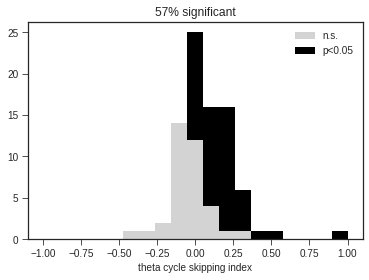

In [148]:
cl_cycle_csi = np.array([k['cycle_skipping_index'] for _,_,k in time_based])
cl_cycle_p = np.array([k['p'] for _,_,k in time_based])

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.hist([cl_cycle_csi[cl_cycle_p>=0.05], cl_cycle_csi[cl_cycle_p<0.05]], bins=np.linspace(-1,1,20), stacked=True, 
        color=['lightgray','black'], label=['n.s.', 'p<0.05'])
ax.legend()
ax.set(title="{:.0f}% significant".format(100*np.mean(cl_cycle_p<0.05)), xlabel="theta cycle skipping index");

In [16]:
#define parameters for spectrogram
bin_size = 0.001
window_size = 2
bandwidth = 1

spectrum_all_clusters=[]
psd={}
fr={}
spikes_b={}
for cl in cluster_ids:
    start, end = spike_t[cl][0] - 0.5 * bin_size, spike_t[cl][-1] + 0.5 * bin_size
    bins = fklab.segments.check_segments(np.arange(start, end, bin_size))
    spikes_b[cl] = fastbin(spike_t[cl], bins)

    psd[cl], fr[cl], _, _ = mt.mtspectrum(spikes_b[cl].ravel(),fs=1.0 / bin_size, window_size=window_size,bandwidth=bandwidth,
        start_time=spike_t[cl][0],epochs=outbound,fpass=[1,50])
    
    spectrum_all_clusters.append((cl, psd,fr))

In [17]:
# Define delta lower and upper limits
low, high = 6, 10
low_t, high_t = 1, 50
# Find intersecting values in frequency vector
idx_theta = np.logical_and(fr[0] >= low, fr[0] <= high)
idx_total = np.logical_and(fr[0] >= low_t, fr[0] <= high_t)

freq_res = fr[0][1] - fr[0][0] 

In [18]:
from scipy.integrate import simps

theta_rel_power_all=[]
theta_power_cl={}
total_power_cl = {}
theta_rel_power_cl = {}
for cl in cluster_ids:
    theta_power_cl[cl] = simps(psd[cl][idx_theta], dx=freq_res)
    total_power_cl[cl] = simps(psd[cl][idx_total], dx=freq_res)
    theta_rel_power_cl[cl] = theta_power_cl[cl] / total_power_cl[cl]
    theta_rel_power_all.append((cl, theta_power_cl, total_power_cl, theta_rel_power_cl))

In [19]:
theta_rel_power_cl

{0: 0.07173139241136084,
 2: 0.07406184499197856,
 7: 0.07834209101820834,
 12: 0.0897514407374091,
 19: 0.12033998729800355,
 20: 0.07930830178482624,
 24: 0.13389904338455696,
 28: 0.07372025234662447,
 29: 0.0628723456406338,
 30: 0.08123827707113698,
 36: 0.08682845104498188,
 39: 0.09002432449939218,
 40: 0.08992372223098108,
 43: 0.09959053658906233,
 46: 0.06951708475027732,
 48: 0.08501238481158367,
 51: 0.10226217247672936,
 52: 0.1702748157026076,
 61: 0.082509587843787,
 62: 0.09803530790127388,
 64: 0.08810843606024019,
 71: 0.06896589392363739,
 77: 0.15667329021969617,
 78: 0.08570478972435905,
 84: 0.0887576671087487,
 93: 0.11314110252351335,
 94: 0.11274426340570601,
 95: 0.09592185257953585,
 97: 0.1060617272096116,
 99: 0.08947068611532664,
 102: 0.14267119662295616,
 111: 0.11992892607653462,
 112: 0.12284668860085249,
 113: 0.11082637884687566,
 114: 0.0837923843511235,
 117: 0.08123028802957252,
 126: 0.09571389441144801,
 133: 0.08873116915990689,
 138: 0.1087750

### Add a random gaussian jitter to each spike 

In [26]:
from fklab.utilities.general import randomize

n=5
shuffled_spikes=[]
shuffled_s={}
for cl in cluster_ids:
    for i in range(n): 
        shuffled_s[i] = spike_t[cl] + np.random.normal(scale=0.5/8., size=spike_t[cl].shape)
        np.sort(shuffled_s[i])
        
        shuffled_spikes.append((cl,shuffled_s ))

In [20]:
n = 5
shuffled_spikes = {}

for cl in cluster_ids:
    shuffled_s = []
    for i in range(n): 
        shuffled_s.append(spike_t[cl] + np.random.normal(scale=0.5/8., size=spike_t[cl].shape))
    shuffled_spikes[cl] = np.sort(shuffled_s, axis=-1)

In [34]:
shuffled_spikes[0][2]

array([1830.54216235, 1830.74714285, 1830.78672015, ..., 4412.05967187,
       4412.18344002, 4412.31419231])

### Calculate power spectrum for shuffled data

In [37]:
psd_s = {}
fr_s = {}
spikes_bin = {}
spectrum_all_shuffled = []

for cl in cluster_ids:

    spikes_sb = []
    _psd_s = []
    _fr_s = []
    for k in range(n):
        start, end = shuffled_spikes[cl][k][0] - 0.5 * bin_size, shuffled_spikes[cl][k][-1] + 0.5 * bin_size
        bins = fklab.segments.check_segments(np.arange(start, end, bin_size))
        spikes_sb.append(fastbin(shuffled_spikes[cl][k], bins))
    
    
        res = mt.mtspectrum(spikes_sb[-1].ravel(), fs=1.0 / bin_size, 
                                                        window_size=window_size,bandwidth=bandwidth,
                                                        start_time=shuffled_spikes[cl][k][0],
                                                       epochs=outbound,fpass=[1,50])
        _psd_s.append(res[0])
        _fr_s.append(res[1])
    spikes_bin[cl] = np.array(spikes_sb)
    psd_s[cl] = np.array(_psd_s)
    fr_s[cl] = np.array(_fr_s)
    spectrum_all_shuffled.append((cl, psd_s[cl],fr_s[cl]))

/home/kasia/miniconda3/envs/fkdev/lib/python3.7/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [61]:
# Define delta lower and upper limits
low, high = 6, 10
low_t, high_t = 1, 50
# Find intersecting values in frequency vector
idx_theta = np.logical_and(fr_s[0][0] >= low, fr_s[0][0] <= high)
idx_total = np.logical_and(fr_s[0][0] >= low_t, fr_s[0][0] <= high_t)

freq_res = fr_s[0][0][1] - fr_s[0][0][0] 

In [66]:
psd_s[cl][1,idx_theta]

array([1.52552458e-05, 1.64240576e-05, 1.52956069e-05, 1.55913295e-05,
       1.60001076e-05, 1.65596111e-05, 1.46933034e-05, 1.53088108e-05,
       1.55377578e-05])

In [92]:
from scipy.integrate import simps

theta_rel_power_s=[]
theta_power_s={}
total_power_s = {}
theta_rel_power_sh = {}
for cl in cluster_ids:
    theta_rel_sh=[]
    theta_p =[]
    total_p=[]
    theta_rel=[]
    for k in range(n):
        theta_p.append(simps(psd_s[cl][k, idx_theta], dx=freq_res))
        total_p.append(simps(psd_s[cl][k, idx_total], dx=freq_res))
        theta_rel_power_s.append(theta_power_s[cl][k] / total_power_s[cl][k])
        
   
        #theta_rel_power_s.append(theta_power_s[cl][k] / total_power_s[cl][k])
    theta_power_s[cl]=np.array(theta_p)
    total_power_s[cl]=np.array(total_p)
    theta_rel_power_sh[cl] = np.array(theta_rel_power_s)

KeyError: 0

In [95]:
theta_power_s[0].shape

KeyError: 0

In [17]:
from fklab.events.basic_algorithms import fastbin
bin_size = 0.001
window_size = 2
bandwidth = 1

start, end = spike_t[210][0] - 0.5 * bin_size, spike_t[210][-1] + 0.5 * bin_size
bins = fklab.segments.check_segments(np.arange(start, end, bin_size))
spikes_b = fastbin(spike_t[210], bins)

psd, fr, _, _ = mt.mtspectrum(spikes_b.ravel(),fs=1.0 / bin_size, window_size=window_size,bandwidth=bandwidth,
        start_time=spike_t[210][0],epochs=outbound,fpass=[1,50])

#psd = 10 * np.log10(psd)

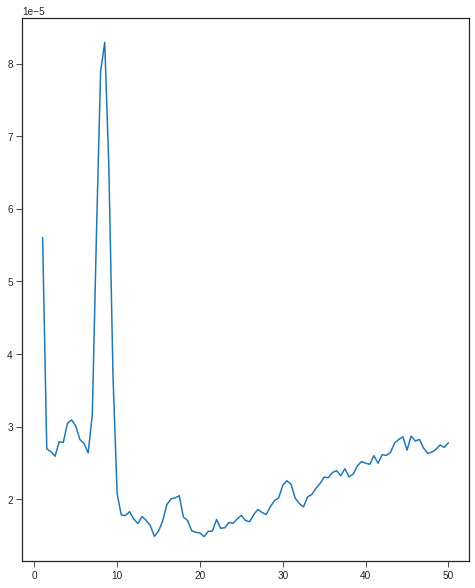

In [18]:
plt.plot(fr, psd)

In [106]:
# Define delta lower and upper limits
low, high = 6, 10
low_t, high_t = 1, 50
# Find intersecting values in frequency vector
idx_theta = np.logical_and(fr >= low, fr <= high)
idx_total = np.logical_and(fr >= low_t, fr <= high_t)

In [107]:
from scipy.integrate import simps
freq_res = fr[1] - fr[0] 
# Compute the absolute power by approximating the area under the curve
theta_power = simps(psd[idx_theta], dx=freq_res)
print('Absolute theta power:', theta_power)

Absolute theta power: 0.0002019540557307508


In [108]:
total_power = simps(psd[idx_total], dx=freq_res)
theta_rel_power = theta_power / total_power
print('Relative theta power:', theta_rel_power)

Relative theta power: 0.16982454583995116


In [155]:
from fklab.utilities.general import randomize

n=500
shuffled_spikes={}
for i in range(n): 
    shuffled_spikes[i] = spike_t[210] + np.random.normal(scale=0.5/8., size=spike_t[210].shape)
    np.sort(shuffled_spikes[i])

In [156]:
psd_s={}
fr_s={}
spike_sb={}
for k in range(len(shuffled_spikes)):
    start_s, end_s = shuffled_spikes[k][0] - 0.5 * bin_size, shuffled_spikes[k][-1] + 0.5 * bin_size
    bins_s = fklab.segments.check_segments(np.arange(start_s, end_s, bin_size))
    spike_sb[k] = fastbin(shuffled_spikes[k], bins)

    psd_s[k], fr_s[k], _, _ = mt.mtspectrum(spike_sb[k].ravel(),fs=1.0 / bin_size, window_size=window_size,bandwidth=bandwidth,
        start_time=shuffled_spikes[k][0], epochs=outbound, fpass=[1,50])

In [160]:
fr_s[0][0]

1.0

In [161]:
# Define delta lower and upper limits
low, high = 6, 10
low_t, high_t = 1, 50
# Find intersecting values in frequency vector
idx_theta = np.logical_and(fr_s[0] >= low, fr_s[0] <= high)
idx_total = np.logical_and(fr_s[0] >= low_t, fr_s[0] <= high_t)

from scipy.integrate import simps
freq_res = fr_s[0][1] - fr_s[0][0] 

In [110]:
theta_power_s={}
total_power_s = {}
theta_rel_power_s = {}
for s in range(len(shuffled_spikes)):
    theta_power_s[s] = simps(psd_s[s][idx_theta], dx=freq_res)
    total_power_s[s] = simps(psd_s[s][idx_total], dx=freq_res)
    theta_rel_power_s[s] = theta_power_s[s] / total_power_s[s]

In [111]:
 random_rel_power = np.array([x for x in theta_rel_power_s])

In [112]:
 p = fklab.statistics.core.monte_carlo_pvalue(
             random_rel_power, theta_rel_power)
print(p)

In [50]:
start_s, end_s = spikes_s[0] - 0.5 * bin_size, spikes_s[-1] + 0.5 * bin_size
bins_s = fklab.segments.check_segments(np.arange(start_s, end_s, bin_size))
spike_sb = fastbin(spikes_s, bins)

psd_s, fr_s, _, _ = mt.mtspectrum(spike_sb.ravel(),fs=1.0 / bin_size, window_size=window_size,bandwidth=bandwidth,
        start_time=spikes_s[0], epochs=outbound, fpass=[1,50])

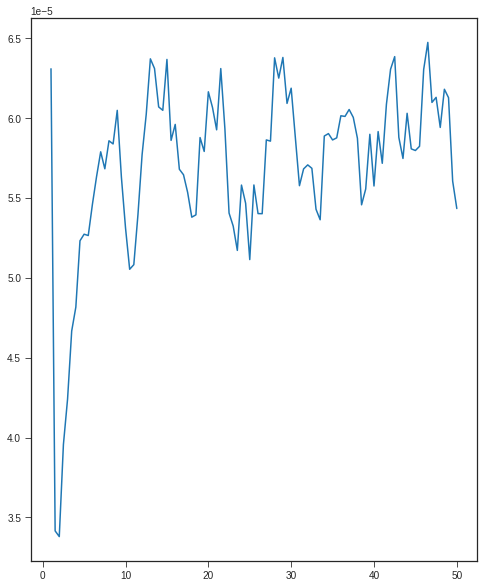

In [115]:
plt.plot(fr_s[50], psd_s[50])

In [122]:
from fklab.utilities.general import randomize

n=500
shuffled_spikes=[]
shuffled_s={}
for cl in cluster_ids:
    for i in range(n): 
        shuffled_s[i] = spike_t[cl] + np.random.normal(scale=0.5/8., size=spike_t[cl].shape)
        np.sort(shuffled_s[i])
        
        shuffled_spikes.append((cl,shuffled_s ))

In [125]:
shuffled_spikes[1][1]

{0: array([1830.79882398, 1831.41606017, 1831.31254151, ..., 4410.37435708,
        4410.7650258 , 4410.9045968 ]),
 1: array([1830.66497491, 1831.31666109, 1831.36745188, ..., 4410.68243338,
        4410.74591501, 4410.98644221]),
 2: array([1830.64182092, 1831.35764286, 1831.38170072, ..., 4410.57826063,
        4410.95285902, 4411.01380187]),
 3: array([1830.67507612, 1831.41210836, 1831.34429412, ..., 4410.46706922,
        4410.88660952, 4410.86357904]),
 4: array([1830.6941608 , 1831.34051414, 1831.32055583, ..., 4410.58495017,
        4410.74468715, 4410.85738559]),
 5: array([1830.62031998, 1831.49104   , 1831.36915605, ..., 4410.6394429 ,
        4410.73766506, 4410.90916244]),
 6: array([1830.66827959, 1831.35917432, 1831.22961301, ..., 4410.60153571,
        4410.91439374, 4410.94380118]),
 7: array([1830.72783597, 1831.33026106, 1831.42727548, ..., 4410.6156343 ,
        4410.76900043, 4410.83341401]),
 8: array([1830.66624307, 1831.35594968, 1831.41687646, ..., 4410.531364

In [166]:
len(psd)

109

In [164]:
# Define delta lower and upper limits
low, high = 6, 10
low_t, high_t = 1, 50
# Find intersecting values in frequency vector
idx_theta = np.logical_and(fr[0] >= low, fr[0] <= high)
idx_total = np.logical_and(fr[0] >= low_t, fr[0] <= high_t)

freq_res = fr[0][1] - fr[0][0] 

In [167]:
theta_power_cl={}
total_power_cl = {}
theta_rel_power_cl = {}
for cl in cluster_ids:
    theta_power_cl[cl] = simps(psd[cl][idx_theta], dx=freq_res)
    total_power_cl[cl] = simps(psd[cl][idx_total], dx=freq_res)
    theta_rel_power_cl[cl] = theta_power_cl[cl] / total_power_cl[cl]

In [ ]:
psd_s={}
fr_s={}
spike_sb={}
spectrum_shuffled=[]
for cl in cluster_ids:
    for k in range(len(shuffled_spikes)):
        start_s, end_s = shuffled_spikes[k][0] - 0.5 * bin_size, shuffled_spikes[k][-1] + 0.5 * bin_size
        bins_s = fklab.segments.check_segments(np.arange(start_s, end_s, bin_size))
        spike_sb[k] = fastbin(shuffled_spikes[k], bins)

    psd_s[k], fr_s[k], _, _ = mt.mtspectrum(spike_sb[k].ravel(),fs=1.0 / bin_size, window_size=window_size,bandwidth=bandwidth,
        start_time=shuffled_spikes[k][0], epochs=outbound, fpass=[1,50])